This is a Jupyter notebook that illustrates the use of the [Julia](https://julialang.org/) language for analyzing and plotting data.  Data is from the 2020 Covid-19 outbreak as stored on the GitHub of Johns Hopkins University

# Setup
Here are all the Packages I use. If you don't have them already set up in your environment, you may have to do a `Pkg.add`

In [1]:
using DataFrames, CSV

In [2]:
using Statistics

In [3]:
using StatsBase

In [4]:
# for histogram()
using StatsPlots

In [5]:
using Plots.PlotMeasures

In [6]:
gr()

Plots.GRBackend()

In [7]:
using Dates

In [8]:
ENV["LINES"] = 72

72

In [9]:
ENV["COLUMNS"] = 90

90

## Helper functions

In [10]:
# calculate new cases by subtracting prior count; shifts back time array by one day
function newcases(a)
    nc = Array{Int64,1}()
    for i in 1:length(a) - 1
        push!(nc, a[i+1] - a[i])
    end
    return nc
end

newcases (generic function with 1 method)

In [11]:
# smooth a time series using an odd sized window; will decrease the time array half the window length off the front and back
function smooth(a, ws)
    if iseven(ws) error("even window for smoothing"); end
    sa = Array{Float64,1}()
    for i in 1:length(a) - ws + 1
        push!(sa, mean(a[i:i+ws-1]))
    end
    return sa
end

smooth (generic function with 1 method)

In [12]:
# to make plotting log scale easier
logprotect(a) = [max(1, x) for x in a]

logprotect (generic function with 1 method)

# Johns Hopkins Data
This is the Covid-19 data made available by Johns Hopkins. You can download from https://github.com/CSSEGISandData/COVID-19

I am only parsing the daily time series summary tables, including confirmed, deaths and recovered. All those data come from the daily case report.

Field description
* Province/State: China - province name; US/Canada/Australia/ - city name, state/province name; Others - name of the event (e.g., "Diamond Princess" cruise ship); other countries - blank.
* Country/Region: country/region name conforming to WHO (will be updated).
* Lat and Long: a coordinates reference for the user.
* Date fields: M/DD/YYYY (UTC), the same data as MM-DD-YYYY.csv file.



In [13]:
# get the latest using GitHub
import GitHub
import Base64

In [14]:
filelist = map(x->x.name, GitHub.directory("CSSEGISandData/COVID-19", "csse_covid_19_data/csse_covid_19_time_series/")[1])[3:end]

6-element Array{String,1}:
 "README.md"
 "time_series_covid19_confirmed_US.csv"
 "time_series_covid19_confirmed_global.csv"
 "time_series_covid19_deaths_US.csv"
 "time_series_covid19_deaths_global.csv"
 "time_series_covid19_recovered_global.csv"

In [15]:
# get paths from tree from sha of tree "csse_covid_19_time_series"
shas = Dict{String, String}()
for p in [(x["path"], x["sha"]) for x in GitHub.tree("CSSEGISandData/COVID-19", 
    [x for x in GitHub.tree("CSSEGISandData/COVID-19", 
                                [x for x in GitHub.tree("CSSEGISandData/COVID-19", 
                                                        GitHub.branch("CSSEGISandData/COVID-19", "master").commit.sha).tree 
                                 if x["path"] == "csse_covid_19_data"][1]["sha"]).tree
     if x["path"] == "csse_covid_19_time_series"][1]["sha"]).tree]
    shas[p[1]] = p[2]
end
shas

Dict{String,String} with 8 entries:
  "time_series_covid19_deaths_global.csv"    => "6e9b9282bcac01390943ee2511ae9cf4097d0374"
  ".gitignore"                               => "496ee2ca6a2f08396a4076fe43dedf3dc0da8b6d"
  "time_series_covid19_confirmed_US.csv"     => "8dda93dd2ba2e01ca15834658b29d304f3a782ce"
  "README.md"                                => "85e61f8d5264f22d822758d79b2297fb8c6bca21"
  "time_series_covid19_deaths_US.csv"        => "fbc6a5491c90fb04af7f3b7d17005ae6bee9e02d"
  "time_series_covid19_recovered_global.csv" => "1569af279128fda4fc7d5dc1858169c9840b01f6"
  "Errata.csv"                               => "90f3524b6ed4699cec86c2e2d4826a9f97d67573"
  "time_series_covid19_confirmed_global.csv" => "00db673b5043e72ab1df766c1584a38353e466ea"

In [16]:
# update files from GitHub
@time for fn in filelist
    open(fn, "w") do f
        write(f, String(Base64.base64decode(
                    GitHub.blob("CSSEGISandData/COVID-19", shas[fn]).content)))
    end
end

  3.968367 seconds (817.63 k allocations: 51.984 MiB, 0.30% gc time)


## US confirmed cases

In [17]:
@time usconf = CSV.read("time_series_covid19_confirmed_US.csv")

  4.583803 seconds (7.84 M allocations: 376.205 MiB, 2.39% gc time)


3261×122 DataFrame. Omitted printing of 117 columns
│ Row  │ UID      │ iso2   │ iso3   │ code3 │ FIPS     │
│      │ Int64    │ String │ String │ Int64 │ Float64⍰ │
├──────┼──────────┼────────┼────────┼───────┼──────────┤
│ 1    │ 16       │ AS     │ ASM    │ 16    │ 60.0     │
│ 2    │ 316      │ GU     │ GUM    │ 316   │ 66.0     │
│ 3    │ 580      │ MP     │ MNP    │ 580   │ 69.0     │
│ 4    │ 630      │ PR     │ PRI    │ 630   │ 72.0     │
│ 5    │ 850      │ VI     │ VIR    │ 850   │ 78.0     │
│ 6    │ 84001001 │ US     │ USA    │ 840   │ 1001.0   │
│ 7    │ 84001003 │ US     │ USA    │ 840   │ 1003.0   │
│ 8    │ 84001005 │ US     │ USA    │ 840   │ 1005.0   │
│ 9    │ 84001007 │ US     │ USA    │ 840   │ 1007.0   │
│ 10   │ 84001009 │ US     │ USA    │ 840   │ 1009.0   │
│ 11   │ 84001011 │ US     │ USA    │ 840   │ 1011.0   │
│ 12   │ 84001013 │ US     │ USA    │ 840   │ 1013.0   │
│ 13   │ 84001015 │ US     │ USA    │ 840   │ 1015.0   │
│ 14   │ 84001017 │ US     │ USA    │ 840   │ 1017.0   │
│ 15   │ 84001019 │ US     │ USA    │ 840   │ 1019.0   │
│ 16   │ 84001021 │ US     │ USA    │ 840   │ 1021.0   │
│ 17   │ 84001023 │ US     │ USA    │ 840   │ 1023.0   │
│ 18   │ 84001025 │ US     │ USA    │ 840   │ 1025.0   │
│ 19   │ 84001027 │ US     │ USA    │ 840   │ 1027.0   │
│ 20   │ 84001029 │ US     │ USA    │ 840   │ 1029.0   │
│ 21   │ 84001031 │ US     │ USA    │ 840   │ 1031.0   │
│ 22   │ 84001033 │ US     │ USA    │ 840   │ 1033.0   │
│ 23   │ 84001035 │ US     │ USA    │ 840   │ 1035.0   │
│ 24   │ 84001037 │ US     │ USA    │ 840   │ 1037.0   │
│ 25   │ 84001039 │ US     │ USA    │ 840   │ 1039.0   │
│ 26   │ 84001041 │ US     │ USA    │ 840   │ 1041.0   │
│ 27   │ 84001043 │ US     │ USA    │ 840   │ 1043.0   │
│ 28   │ 84001045 │ US     │ USA    │ 840   │ 1045.0   │
│ 29   │ 84001047 │ US     │ USA    │ 840   │ 1047.0   │
│ 30   │ 84001049 │ US     │ USA    │ 840   │ 1049.0   │
│ 31   │ 84001051 │ US     │ USA    │ 840   │ 1051.0   │
⋮
│ 3230 │ 84090032 │ US     │ USA    │ 840   │ 90032.0  │
│ 3231 │ 84090033 │ US     │ USA    │ 840   │ 90033.0  │
│ 3232 │ 84090034 │ US     │ USA    │ 840   │ 90034.0  │
│ 3233 │ 84090035 │ US     │ USA    │ 840   │ 90035.0  │
│ 3234 │ 84090036 │ US     │ USA    │ 840   │ 90036.0  │
│ 3235 │ 84090037 │ US     │ USA    │ 840   │ 90037.0  │
│ 3236 │ 84090038 │ US     │ USA    │ 840   │ 90038.0  │
│ 3237 │ 84090039 │ US     │ USA    │ 840   │ 90039.0  │
│ 3238 │ 84090040 │ US     │ USA    │ 840   │ 90040.0  │
│ 3239 │ 84090041 │ US     │ USA    │ 840   │ 90041.0  │
│ 3240 │ 84090042 │ US     │ USA    │ 840   │ 90042.0  │
│ 3241 │ 84090044 │ US     │ USA    │ 840   │ 90044.0  │
│ 3242 │ 84090045 │ US     │ USA    │ 840   │ 90045.0  │
│ 3243 │ 84090046 │ US     │ USA    │ 840   │ 90046.0  │
│ 3244 │ 84090047 │ US     │ USA    │ 840   │ 90047.0  │
│ 3245 │ 84090048 │ US     │ USA    │ 840   │ 90048.0  │
│ 3246 │ 84090049 │ US     │ USA    │ 840   │ 90049.0  │
│ 3247 │ 84090050 │ US     │ USA    │ 840   │ 90050.0  │
│ 3248 │ 84090051 │ US     │ USA    │ 840   │ 90051.0  │
│ 3249 │ 84090053 │ US     │ USA    │ 840   │ 90053.0  │
│ 3250 │ 84090054 │ US     │ USA    │ 840   │ 90054.0  │
│ 3251 │ 84090055 │ US     │ USA    │ 840   │ 90055.0  │
│ 3252 │ 84090056 │ US     │ USA    │ 840   │ 90056.0  │
│ 3253 │ 84099999 │ US     │ USA    │ 840   │ 99999.0  │
│ 3254 │ 84070004 │ US     │ USA    │ 840   │ missing  │
│ 3255 │ 84070005 │ US     │ USA    │ 840   │ missing  │
│ 3256 │ 84070015 │ US     │ USA    │ 840   │ missing  │
│ 3257 │ 84070016 │ US     │ USA    │ 840   │ missing  │
│ 3258 │ 84070017 │ US     │ USA    │ 840   │ missing  │
│ 3259 │ 84070018 │ US     │ USA    │ 840   │ missing  │
│ 3260 │ 84070019 │ US     │ USA    │ 840   │ missing  │
│ 3261 │ 84070020 │ US     │ USA    │ 840   │ missing  │

In [18]:
describe(usconf)

122×8 DataFrame. Omitted printing of 4 columns
│ Row │ variable       │ mean        │ min                           │ median    │
│     │ Symbol         │ Union…      │ Any                           │ Union…    │
├─────┼────────────────┼─────────────┼───────────────────────────────┼───────────┤
│ 1   │ UID            │ 8.39034e7   │ 16                            │ 8.40301e7 │
│ 2   │ iso2           │             │ AS                            │           │
│ 3   │ iso3           │             │ ASM                           │           │
│ 4   │ code3          │ 839.446     │ 16                            │ 840.0     │
│ 5   │ FIPS           │ 32090.9     │ 60.0                          │ 30045.0   │
│ 6   │ Admin2         │             │ Abbeville                     │           │
│ 7   │ Province_State │             │ Alabama                       │           │
│ 8   │ Country_Region │             │ US                            │           │
│ 9   │ Lat            │ 37.1659     │ -14.271                       │ 38.149    │
│ 10  │ Long_          │ -89.1604    │ -170.132                      │ -89.8274  │
│ 11  │ Combined_Key   │             │ Abbeville, South Carolina, US │           │
│ 12  │ 1/22/20        │ 0.000306654 │ 0                             │ 0.0       │
│ 13  │ 1/23/20        │ 0.000306654 │ 0                             │ 0.0       │
│ 14  │ 1/24/20        │ 0.000613309 │ 0                             │ 0.0       │
│ 15  │ 1/25/20        │ 0.000613309 │ 0                             │ 0.0       │
│ 16  │ 1/26/20        │ 0.00153327  │ 0                             │ 0.0       │
│ 17  │ 1/27/20        │ 0.00153327  │ 0                             │ 0.0       │
│ 18  │ 1/28/20        │ 0.00153327  │ 0                             │ 0.0       │
│ 19  │ 1/29/20        │ 0.00153327  │ 0                             │ 0.0       │
│ 20  │ 1/30/20        │ 0.00153327  │ 0                             │ 0.0       │
│ 21  │ 1/31/20        │ 0.00214658  │ 0                             │ 0.0       │
│ 22  │ 2/1/20         │ 0.00245324  │ 0                             │ 0.0       │
│ 23  │ 2/2/20         │ 0.00245324  │ 0                             │ 0.0       │
│ 24  │ 2/3/20         │ 0.0033732   │ 0                             │ 0.0       │
│ 25  │ 2/4/20         │ 0.0033732   │ 0                             │ 0.0       │
│ 26  │ 2/5/20         │ 0.0033732   │ 0                             │ 0.0       │
│ 27  │ 2/6/20         │ 0.0033732   │ 0                             │ 0.0       │
│ 28  │ 2/7/20         │ 0.0033732   │ 0                             │ 0.0       │
│ 29  │ 2/8/20         │ 0.0033732   │ 0                             │ 0.0       │
│ 30  │ 2/9/20         │ 0.0033732   │ 0                             │ 0.0       │
│ 31  │ 2/10/20        │ 0.0033732   │ 0                             │ 0.0       │
⋮
│ 91  │ 4/10/20        │ 152.265     │ 0                             │ 6.0       │
│ 92  │ 4/11/20        │ 161.422     │ 0                             │ 7.0       │
│ 93  │ 4/12/20        │ 170.289     │ 0                             │ 7.0       │
│ 94  │ 4/13/20        │ 178.049     │ 0                             │ 8.0       │
│ 95  │ 4/14/20        │ 186.345     │ 0                             │ 8.0       │
│ 96  │ 4/15/20        │ 195.14      │ 0                             │ 8.0       │
│ 97  │ 4/16/20        │ 204.72      │ 0                             │ 9.0       │
│ 98  │ 4/17/20        │ 214.568     │ 0                             │ 10.0      │
│ 99  │ 4/18/20        │ 223.232     │ 0                             │ 10.0      │
│ 100 │ 4/19/20        │ 231.333     │ 0                             │ 10.0      │
│ 101 │ 4/20/20        │ 239.093     │ 0                             │ 11.0      │
│ 102 │ 4/21/20        │ 247.477     │ 0                             │ 11.0      │
│ 103 │ 4/22/20        │ 256.102     │ 0                             │ 12.0      │
│ 104 │ 4/23/20        │ 266.535     │ 0          

In [19]:
confdaterange = 12:length(names(usconf)[12:end]) + 12 -1

12:122

In [20]:
# create an Array of Date for xaxis plotting
@time datelist = Date.(string.(names(usconf)[confdaterange]), "m/dd/yy") .+ Year(2000)

  0.556461 seconds (1.21 M allocations: 60.682 MiB, 4.25% gc time)


111-element Array{Date,1}:
 2020-01-22
 2020-01-23
 2020-01-24
 2020-01-25
 2020-01-26
 2020-01-27
 2020-01-28
 2020-01-29
 2020-01-30
 2020-01-31
 2020-02-01
 2020-02-02
 2020-02-03
 2020-02-04
 2020-02-05
 2020-02-06
 2020-02-07
 2020-02-08
 2020-02-09
 2020-02-10
 2020-02-11
 2020-02-12
 2020-02-13
 2020-02-14
 2020-02-15
 2020-02-16
 2020-02-17
 2020-02-18
 2020-02-19
 2020-02-20
 2020-02-21
 2020-02-22
 2020-02-23
 2020-02-24
 ⋮
 2020-04-09
 2020-04-10
 2020-04-11
 2020-04-12
 2020-04-13
 2020-04-14
 2020-04-15
 2020-04-16
 2020-04-17
 2020-04-18
 2020-04-19
 2020-04-20
 2020-04-21
 2020-04-22
 2020-04-23
 2020-04-24
 2020-04-25
 2020-04-26
 2020-04-27
 2020-04-28
 2020-04-29
 2020-04-30
 2020-05-01
 2020-05-02
 2020-05-03
 2020-05-04
 2020-05-05
 2020-05-06
 2020-05-07
 2020-05-08
 2020-05-09
 2020-05-10
 2020-05-11

In [21]:
# Array of State names as String
states = unique(usconf.Province_State)

58-element Array{String,1}:
 "American Samoa"
 "Guam"
 "Northern Mariana Islands"
 "Puerto Rico"
 "Virgin Islands"
 "Alabama"
 "Alaska"
 "Arizona"
 "Arkansas"
 "California"
 "Colorado"
 "Connecticut"
 "Delaware"
 "District of Columbia"
 "Florida"
 "Georgia"
 "Hawaii"
 "Idaho"
 "Illinois"
 "Indiana"
 "Iowa"
 "Kansas"
 "Kentucky"
 "Louisiana"
 "Maine"
 "Maryland"
 "Massachusetts"
 "Michigan"
 "Minnesota"
 "Mississippi"
 "Missouri"
 "Montana"
 "Nebraska"
 "Nevada"
 "New Hampshire"
 "New Jersey"
 "New Mexico"
 "New York"
 "North Carolina"
 "North Dakota"
 "Ohio"
 "Oklahoma"
 "Oregon"
 "Pennsylvania"
 "Rhode Island"
 "South Carolina"
 "South Dakota"
 "Tennessee"
 "Texas"
 "Utah"
 "Vermont"
 "Virginia"
 "Washington"
 "West Virginia"
 "Wisconsin"
 "Wyoming"
 "Diamond Princess"
 "Grand Princess"

## US deaths

In [22]:
@time usdeath = CSV.read("time_series_covid19_deaths_US.csv")

  0.010324 seconds (3.21 k allocations: 7.298 MiB)


3261×123 DataFrame. Omitted printing of 118 columns
│ Row  │ UID      │ iso2   │ iso3   │ code3 │ FIPS     │
│      │ Int64    │ String │ String │ Int64 │ Float64⍰ │
├──────┼──────────┼────────┼────────┼───────┼──────────┤
│ 1    │ 16       │ AS     │ ASM    │ 16    │ 60.0     │
│ 2    │ 316      │ GU     │ GUM    │ 316   │ 66.0     │
│ 3    │ 580      │ MP     │ MNP    │ 580   │ 69.0     │
│ 4    │ 630      │ PR     │ PRI    │ 630   │ 72.0     │
│ 5    │ 850      │ VI     │ VIR    │ 850   │ 78.0     │
│ 6    │ 84001001 │ US     │ USA    │ 840   │ 1001.0   │
│ 7    │ 84001003 │ US     │ USA    │ 840   │ 1003.0   │
│ 8    │ 84001005 │ US     │ USA    │ 840   │ 1005.0   │
│ 9    │ 84001007 │ US     │ USA    │ 840   │ 1007.0   │
│ 10   │ 84001009 │ US     │ USA    │ 840   │ 1009.0   │
│ 11   │ 84001011 │ US     │ USA    │ 840   │ 1011.0   │
│ 12   │ 84001013 │ US     │ USA    │ 840   │ 1013.0   │
│ 13   │ 84001015 │ US     │ USA    │ 840   │ 1015.0   │
│ 14   │ 84001017 │ US     │ USA    │ 840   │ 1017.0   │
│ 15   │ 84001019 │ US     │ USA    │ 840   │ 1019.0   │
│ 16   │ 84001021 │ US     │ USA    │ 840   │ 1021.0   │
│ 17   │ 84001023 │ US     │ USA    │ 840   │ 1023.0   │
│ 18   │ 84001025 │ US     │ USA    │ 840   │ 1025.0   │
│ 19   │ 84001027 │ US     │ USA    │ 840   │ 1027.0   │
│ 20   │ 84001029 │ US     │ USA    │ 840   │ 1029.0   │
│ 21   │ 84001031 │ US     │ USA    │ 840   │ 1031.0   │
│ 22   │ 84001033 │ US     │ USA    │ 840   │ 1033.0   │
│ 23   │ 84001035 │ US     │ USA    │ 840   │ 1035.0   │
│ 24   │ 84001037 │ US     │ USA    │ 840   │ 1037.0   │
│ 25   │ 84001039 │ US     │ USA    │ 840   │ 1039.0   │
│ 26   │ 84001041 │ US     │ USA    │ 840   │ 1041.0   │
│ 27   │ 84001043 │ US     │ USA    │ 840   │ 1043.0   │
│ 28   │ 84001045 │ US     │ USA    │ 840   │ 1045.0   │
│ 29   │ 84001047 │ US     │ USA    │ 840   │ 1047.0   │
│ 30   │ 84001049 │ US     │ USA    │ 840   │ 1049.0   │
│ 31   │ 84001051 │ US     │ USA    │ 840   │ 1051.0   │
⋮
│ 3230 │ 84090032 │ US     │ USA    │ 840   │ 90032.0  │
│ 3231 │ 84090033 │ US     │ USA    │ 840   │ 90033.0  │
│ 3232 │ 84090034 │ US     │ USA    │ 840   │ 90034.0  │
│ 3233 │ 84090035 │ US     │ USA    │ 840   │ 90035.0  │
│ 3234 │ 84090036 │ US     │ USA    │ 840   │ 90036.0  │
│ 3235 │ 84090037 │ US     │ USA    │ 840   │ 90037.0  │
│ 3236 │ 84090038 │ US     │ USA    │ 840   │ 90038.0  │
│ 3237 │ 84090039 │ US     │ USA    │ 840   │ 90039.0  │
│ 3238 │ 84090040 │ US     │ USA    │ 840   │ 90040.0  │
│ 3239 │ 84090041 │ US     │ USA    │ 840   │ 90041.0  │
│ 3240 │ 84090042 │ US     │ USA    │ 840   │ 90042.0  │
│ 3241 │ 84090044 │ US     │ USA    │ 840   │ 90044.0  │
│ 3242 │ 84090045 │ US     │ USA    │ 840   │ 90045.0  │
│ 3243 │ 84090046 │ US     │ USA    │ 840   │ 90046.0  │
│ 3244 │ 84090047 │ US     │ USA    │ 840   │ 90047.0  │
│ 3245 │ 84090048 │ US     │ USA    │ 840   │ 90048.0  │
│ 3246 │ 84090049 │ US     │ USA    │ 840   │ 90049.0  │
│ 3247 │ 84090050 │ US     │ USA    │ 840   │ 90050.0  │
│ 3248 │ 84090051 │ US     │ USA    │ 840   │ 90051.0  │
│ 3249 │ 84090053 │ US     │ USA    │ 840   │ 90053.0  │
│ 3250 │ 84090054 │ US     │ USA    │ 840   │ 90054.0  │
│ 3251 │ 84090055 │ US     │ USA    │ 840   │ 90055.0  │
│ 3252 │ 84090056 │ US     │ USA    │ 840   │ 90056.0  │
│ 3253 │ 84099999 │ US     │ USA    │ 840   │ 99999.0  │
│ 3254 │ 84070004 │ US     │ USA    │ 840   │ missing  │
│ 3255 │ 84070005 │ US     │ USA    │ 840   │ missing  │
│ 3256 │ 84070015 │ US     │ USA    │ 840   │ missing  │
│ 3257 │ 84070016 │ US     │ USA    │ 840   │ missing  │
│ 3258 │ 84070017 │ US     │ USA    │ 840   │ missing  │
│ 3259 │ 84070018 │ US     │ USA    │ 840   │ missing  │
│ 3260 │ 84070019 │ US     │ USA    │ 840   │ missing  │
│ 3261 │ 84070020 │ US     │ USA    │ 840   │ missing  │

In [23]:
describe(usdeath)

123×8 DataFrame. Omitted printing of 4 columns
│ Row │ variable       │ mean      │ min                           │ median    │
│     │ Symbol         │ Union…    │ Any                           │ Union…    │
├─────┼────────────────┼───────────┼───────────────────────────────┼───────────┤
│ 1   │ UID            │ 8.39034e7 │ 16                            │ 8.40301e7 │
│ 2   │ iso2           │           │ AS                            │           │
│ 3   │ iso3           │           │ ASM                           │           │
│ 4   │ code3          │ 839.446   │ 16                            │ 840.0     │
│ 5   │ FIPS           │ 32090.9   │ 60.0                          │ 30045.0   │
│ 6   │ Admin2         │           │ Abbeville                     │           │
│ 7   │ Province_State │           │ Alabama                       │           │
│ 8   │ Country_Region │           │ US                            │           │
│ 9   │ Lat            │ 37.1659   │ -14.271                       │ 38.149    │
│ 10  │ Long_          │ -89.1604  │ -170.132                      │ -89.8274  │
│ 11  │ Combined_Key   │           │ Abbeville, South Carolina, US │           │
│ 12  │ Population     │ 103103.0  │ 0                             │ 24558.0   │
│ 13  │ 1/22/20        │ 0.0       │ 0                             │ 0.0       │
│ 14  │ 1/23/20        │ 0.0       │ 0                             │ 0.0       │
│ 15  │ 1/24/20        │ 0.0       │ 0                             │ 0.0       │
│ 16  │ 1/25/20        │ 0.0       │ 0                             │ 0.0       │
│ 17  │ 1/26/20        │ 0.0       │ 0                             │ 0.0       │
│ 18  │ 1/27/20        │ 0.0       │ 0                             │ 0.0       │
│ 19  │ 1/28/20        │ 0.0       │ 0                             │ 0.0       │
│ 20  │ 1/29/20        │ 0.0       │ 0                             │ 0.0       │
│ 21  │ 1/30/20        │ 0.0       │ 0                             │ 0.0       │
│ 22  │ 1/31/20        │ 0.0       │ 0                             │ 0.0       │
│ 23  │ 2/1/20         │ 0.0       │ 0                             │ 0.0       │
│ 24  │ 2/2/20         │ 0.0       │ 0                             │ 0.0       │
│ 25  │ 2/3/20         │ 0.0       │ 0                             │ 0.0       │
│ 26  │ 2/4/20         │ 0.0       │ 0                             │ 0.0       │
│ 27  │ 2/5/20         │ 0.0       │ 0                             │ 0.0       │
│ 28  │ 2/6/20         │ 0.0       │ 0                             │ 0.0       │
│ 29  │ 2/7/20         │ 0.0       │ 0                             │ 0.0       │
│ 30  │ 2/8/20         │ 0.0       │ 0                             │ 0.0       │
│ 31  │ 2/9/20         │ 0.0       │ 0                             │ 0.0       │
⋮
│ 92  │ 4/10/20        │ 6.84851   │ 0                             │ 0.0       │
│ 93  │ 4/11/20        │ 7.46458   │ 0                             │ 0.0       │
│ 94  │ 4/12/20        │ 7.99939   │ 0                             │ 0.0       │
│ 95  │ 4/13/20        │ 8.54646   │ 0                             │ 0.0       │
│ 96  │ 4/14/20        │ 9.27998   │ 0                             │ 0.0       │
│ 97  │ 4/15/20        │ 10.038    │ 0                             │ 0.0       │
│ 98  │ 4/16/20        │ 10.6799   │ 0                             │ 0.0       │
│ 99  │ 4/17/20        │ 11.4722   │ 0                             │ 0.0       │
│ 100 │ 4/18/20        │ 12.1904   │ 0                             │ 0.0       │
│ 101 │ 4/19/20        │ 12.556    │ 0                             │ 0.0       │
│ 102 │ 4/20/20        │ 13.0816   │ 0                             │ 0.0       │
│ 103 │ 4/21/20        │ 13.8258   │ 0                             │ 0.0       │
│ 104 │ 4/22/20        │ 14.5391   │ 0                             │ 0.0       │
│ 105 │ 4/23/20        │ 15.2481   │ 0                             │ 0.0       │
│ 106 │ 4/24/20        │ 15.7906   │ 0                         

In [24]:
deathdaterange = 13:length(names(usdeath)[13:end]) + 13 -1

13:123

## organize data by state

In [25]:
# create a dataframe to organize statistics with State for each row
@time statereports = DataFrame(state = states)
stateconfirm = Dict{String, Vector{Int}}()
statedeath = Dict{String, Vector{Int}}()
statereports.confirm1 = fill(Date(1), length(states))
statereports.confirm2 = fill(Date(1), length(states))
statereports.confirm5 = fill(Date(1), length(states))
statereports.confirmlast = zeros(Int64, length(states))
statereports.death1 = fill(Date(1), length(states))
statereports.death2 = fill(Date(1), length(states))
statereports.death5 = fill(Date(1), length(states))
statereports.deathlast = zeros(Int64, length(states))
statereports.pop = zeros(Int64, length(states))
statereports.maxnewconfirm = fill(Date(1), length(states))
statereports.maxnewdeath = fill(Date(1), length(states))

  0.071369 seconds (81.86 k allocations: 4.164 MiB)


58-element Array{Date,1}:
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01

In [26]:
# populate statereports and sum data for each State for each day
@time for (i, s) in enumerate(states)
    stateconfirm[s] = sum.(eachcol(groupby(usconf, :Province_State)[i][:, confdaterange]))
    statedeath[s] = sum.(eachcol(groupby(usdeath, :Province_State)[i][:, deathdaterange]))
    fd = findfirst(x->x>0, stateconfirm[s])
    if fd != nothing statereports.confirm1[i] = datelist[fd]; end
    fd = findfirst(x->x>1, stateconfirm[s])
    if fd != nothing statereports.confirm2[i] = datelist[fd]; end
    fd = findfirst(x->x>4, stateconfirm[s])
    if fd != nothing statereports.confirm5[i] = datelist[fd]; end
    statereports.confirmlast[i] = stateconfirm[s][end]
    fd = findfirst(x->x>0, statedeath[s])
    if fd != nothing statereports.death1[i] = datelist[fd]; end
    fd = findfirst(x->x>1, statedeath[s])
    if fd != nothing statereports.death2[i] = datelist[fd]; end
    fd = findfirst(x->x>4, statedeath[s])
    if fd != nothing statereports.death5[i] = datelist[fd]; end
    statereports.deathlast[i] = statedeath[s][end]
    statereports.pop[i] = sum(groupby(usdeath, :Province_State)[i].Population)
    a = newcases(stateconfirm[s])
    a1 = findfirst(x->x==maximum(a), a)
    statereports.maxnewconfirm[i] = datelist[2:end][a1 + div(findlast(x->x==maximum(a), a) - a1, 2)]
    a = newcases(statedeath[s])
    a1 = findfirst(x->x==maximum(a), a)
    statereports.maxnewdeath[i] = datelist[2:end][a1 + div(findlast(x->x==maximum(a), a) - a1, 2)]
end

  2.012836 seconds (5.73 M allocations: 300.380 MiB, 6.05% gc time)


  9.054628 seconds (14.88 M allocations: 735.618 MiB, 6.74% gc time)
  0.324134 seconds (1.57 M allocations: 74.814 MiB, 4.52% gc time)


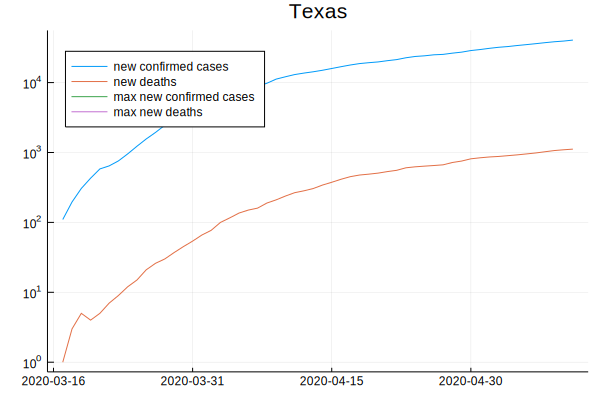

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [27]:
# log raw plot starting with first death
si = findfirst(x->x=="Texas", states)
di = findfirst(x->x==statereports.death1[findfirst(x->x=="Texas", states)], datelist)
@time plot(datelist[di:end], stateconfirm["Texas"][di:end], title="Texas", label="new confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(datelist[di:end], statedeath["Texas"][di:end], title="Texas", label="new deaths")
vline!([statereports.maxnewconfirm[si]], label="max new confirmed cases")
vline!([statereports.maxnewdeath[si]], label="max new deaths")

  0.031618 seconds (63.97 k allocations: 2.975 MiB)
  0.000592 seconds (1.64 k allocations: 101.305 KiB)


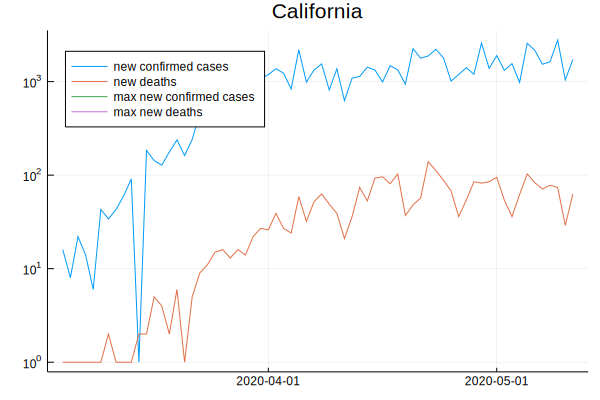

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [28]:
# log new cases plot starting with first death
si = findfirst(x->x=="California", states)
di = findfirst(x->x==statereports.death1[si], datelist)
@time plot(datelist[di+1:end], logprotect(newcases(stateconfirm["California"][di:end])), title="California", label="new confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(datelist[di+1:end], logprotect(newcases(statedeath["California"][di:end])), title="California", label="new deaths")
vline!([statereports.maxnewconfirm[si]], label="max new confirmed cases")
vline!([statereports.maxnewdeath[si]], label="max new deaths")

  0.040022 seconds (66.02 k allocations: 3.156 MiB)
  0.000705 seconds (1.64 k allocations: 99.336 KiB)


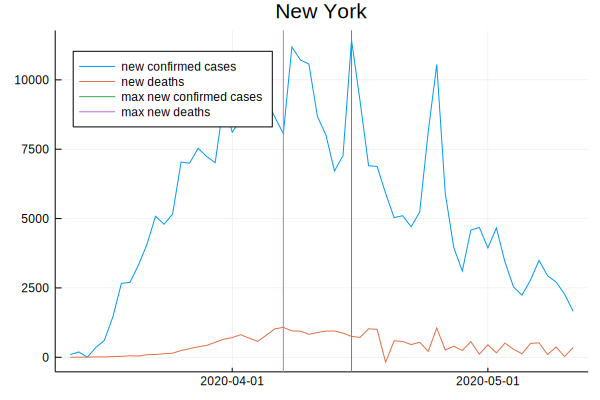

In [29]:
si = findfirst(x->x=="New York", states)
fi = findfirst(x->x==statereports.death1[si], datelist)
@time plot(datelist[fi+1:end], newcases(stateconfirm["New York"][fi:end]), title="New York", label="new confirmed cases", legend=:topleft, )
@time plot!(datelist[fi+1:end], newcases(statedeath["New York"][fi:end]), title="New York", label="new deaths")
vline!([statereports.maxnewconfirm[si]], label="max new confirmed cases")
vline!([statereports.maxnewdeath[si]], label="max new deaths")

In [30]:
statereports[49, :]

DataFrameRow. Omitted printing of 6 columns
│ Row │ state  │ confirm1   │ confirm2   │ confirm5   │ confirmlast │ death1     │
│     │ String │ Date       │ Date       │ Date       │ Int64       │ Date       │
├─────┼────────┼────────────┼────────────┼────────────┼─────────────┼────────────┤
│ 49  │ Texas  │ 2020-03-05 │ 2020-03-05 │ 2020-03-07 │ 40555       │ 2020-03-17 │

In [31]:
Dates.value(statereports.confirm5[49] - statereports.confirm1[49])

2

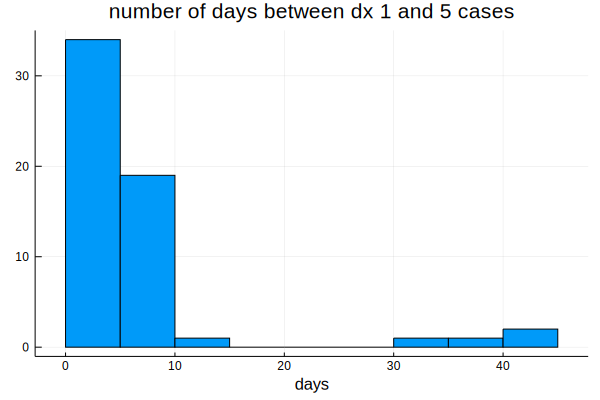

In [32]:
# some States have a big difference between first case and the next
histogram(Dates.value.(statereports.confirm5 - statereports.confirm1), legend=false, bins=15, xlabel="days", title="number of days between dx 1 and 5 cases")

In [33]:
# mean days for 1-5 increase in confirmed cases
mean(Dates.value.(statereports.confirm5 - statereports.confirm1))

5.931034482758621

In [34]:
# standard dev days for 1-5 increase in confirmed cases
std(Dates.value.(statereports.confirm5 - statereports.confirm1))

9.574934508438966

In [35]:
# kind of obvious from the plot, but just to check
skewness(Dates.value.(statereports.confirm5 - statereports.confirm1))

3.0272356722297884

## Global confirmed cases

In [36]:
@time globalconf = CSV.read("time_series_covid19_confirmed_global.csv")

  0.212792 seconds (274.22 k allocations: 14.152 MiB, 14.16% gc time)


266×115 DataFrame. Omitted printing of 111 columns
│ Row │ Province/State                   │ Country/Region         │ Lat      │ Long     │
│     │ Union{Missing, String}           │ String                 │ Float64  │ Float64  │
├─────┼──────────────────────────────────┼────────────────────────┼──────────┼──────────┤
│ 1   │ missing                          │ Afghanistan            │ 33.0     │ 65.0     │
│ 2   │ missing                          │ Albania                │ 41.1533  │ 20.1683  │
│ 3   │ missing                          │ Algeria                │ 28.0339  │ 1.6596   │
│ 4   │ missing                          │ Andorra                │ 42.5063  │ 1.5218   │
│ 5   │ missing                          │ Angola                 │ -11.2027 │ 17.8739  │
│ 6   │ missing                          │ Antigua and Barbuda    │ 17.0608  │ -61.7964 │
│ 7   │ missing                          │ Argentina              │ -38.4161 │ -63.6167 │
│ 8   │ missing                          │ Armenia                │ 40.0691  │ 45.0382  │
│ 9   │ Australian Capital Territory     │ Australia              │ -35.4735 │ 149.012  │
│ 10  │ New South Wales                  │ Australia              │ -33.8688 │ 151.209  │
│ 11  │ Northern Territory               │ Australia              │ -12.4634 │ 130.846  │
│ 12  │ Queensland                       │ Australia              │ -28.0167 │ 153.4    │
│ 13  │ South Australia                  │ Australia              │ -34.9285 │ 138.601  │
│ 14  │ Tasmania                         │ Australia              │ -41.4545 │ 145.971  │
│ 15  │ Victoria                         │ Australia              │ -37.8136 │ 144.963  │
│ 16  │ Western Australia                │ Australia              │ -31.9505 │ 115.861  │
│ 17  │ missing                          │ Austria                │ 47.5162  │ 14.5501  │
│ 18  │ missing                          │ Azerbaijan             │ 40.1431  │ 47.5769  │
│ 19  │ missing                          │ Bahamas                │ 25.0343  │ -77.3963 │
│ 20  │ missing                          │ Bahrain                │ 26.0275  │ 50.55    │
│ 21  │ missing                          │ Bangladesh             │ 23.685   │ 90.3563  │
│ 22  │ missing                          │ Barbados               │ 13.1939  │ -59.5432 │
│ 23  │ missing                          │ Belarus                │ 53.7098  │ 27.9534  │
│ 24  │ missing                          │ Belgium                │ 50.8333  │ 4.0      │
│ 25  │ missing                          │ Benin                  │ 9.3077   │ 2.3158   │
│ 26  │ missing                          │ Bhutan                 │ 27.5142  │ 90.4336  │
│ 27  │ missing                          │ Bolivia                │ -16.2902 │ -63.5887 │
│ 28  │ missing                          │ Bosnia and Herzegovina │ 43.9159  │ 17.6791  │
│ 29  │ missing                          │ Brazil                 │ -14.235  │ -51.9253 │
│ 30  │ missing                          │ Brunei                 │ 4.5353   │ 114.728  │
│ 31  │ missing                          │ Bulgaria               │ 42.7339  │ 25.4858  │
⋮
│ 235 │ missing                          │ Mozambique             │ -18.6657 │ 35.5296  │
│ 236 │ missing                          │ Syria                  │ 34.8021  │ 38.9968  │
│ 237 │ missing                          │ Timor-Leste            │ -8.87422 │ 125.728  │
│ 238 │ missing                          │ Belize                 │ 13.1939  │ -59.5432 │
│ 239 │ Recovered                        │ Canada                 │ 0.0      │ 0.0      │
│ 240 │ missing                          │ Laos                   │ 19.8563  │ 102.495  │
│ 241 │ missing                          │ Libya                  │ 26.3351  │ 17.2283  │
│ 242 │ missing                          │ West Bank and Gaza     │ 31.9522  │ 35.2332  │
│ 243 │ missing                          │ Guinea-Bissau          │ 11.8037  │ -15.1804 │
│ 244 │ missing                          │ Mali                   │ 17.5707  

In [37]:
describe(globalconf)

115×8 DataFrame. Omitted printing of 1 columns
│ Row │ variable       │ mean    │ min         │ median  │ max      │ nunique │ nmissing │
│     │ Symbol         │ Union…  │ Any         │ Union…  │ Any      │ Union…  │ Union…   │
├─────┼────────────────┼─────────┼─────────────┼─────────┼──────────┼─────────┼──────────┤
│ 1   │ Province/State │         │ Alberta     │         │ Zhejiang │ 82      │ 184      │
│ 2   │ Country/Region │         │ Afghanistan │         │ Zimbabwe │ 187     │          │
│ 3   │ Lat            │ 21.2594 │ -51.7963    │ 23.4881 │ 71.7069  │         │          │
│ 4   │ Long           │ 22.4325 │ -135.0      │ 20.9212 │ 178.065  │         │          │
│ 5   │ 1/22/20        │ 2.08647 │ 0           │ 0.0     │ 444      │         │          │
│ 6   │ 1/23/20        │ 2.45865 │ 0           │ 0.0     │ 444      │         │          │
│ 7   │ 1/24/20        │ 3.53759 │ 0           │ 0.0     │ 549      │         │          │
│ 8   │ 1/25/20        │ 5.39098 │ 0           │ 0.0     │ 761      │         │          │
│ 9   │ 1/26/20        │ 7.96241 │ 0           │ 0.0     │ 1058     │         │          │
│ 10  │ 1/27/20        │ 11.0038 │ 0           │ 0.0     │ 1423     │         │          │
│ 11  │ 1/28/20        │ 20.9699 │ 0           │ 0.0     │ 3554     │         │          │
│ 12  │ 1/29/20        │ 23.1805 │ 0           │ 0.0     │ 3554     │         │          │
│ 13  │ 1/30/20        │ 30.9549 │ 0           │ 0.0     │ 4903     │         │          │
│ 14  │ 1/31/20        │ 37.3195 │ 0           │ 0.0     │ 5806     │         │          │
│ 15  │ 2/1/20         │ 45.2556 │ 0           │ 0.0     │ 7153     │         │          │
│ 16  │ 2/2/20         │ 63.109  │ 0           │ 0.0     │ 11177    │         │          │
│ 17  │ 2/3/20         │ 74.7406 │ 0           │ 0.0     │ 13522    │         │          │
│ 18  │ 2/4/20         │ 89.8195 │ 0           │ 0.0     │ 16678    │         │          │
│ 19  │ 2/5/20         │ 103.891 │ 0           │ 0.0     │ 19665    │         │          │
│ 20  │ 2/6/20         │ 115.767 │ 0           │ 0.0     │ 22112    │         │          │
│ 21  │ 2/7/20         │ 129.289 │ 0           │ 0.0     │ 24953    │         │          │
│ 22  │ 2/8/20         │ 139.549 │ 0           │ 0.0     │ 27100    │         │          │
│ 23  │ 2/9/20         │ 150.94  │ 0           │ 0.0     │ 29631    │         │          │
│ 24  │ 2/10/20        │ 160.759 │ 0           │ 0.0     │ 31728    │         │          │
│ 25  │ 2/11/20        │ 168.429 │ 0           │ 0.0     │ 33366    │         │          │
│ 26  │ 2/12/20        │ 170.004 │ 0           │ 0.0     │ 33366    │         │          │
│ 27  │ 2/13/20        │ 226.947 │ 0           │ 0.0     │ 48206    │         │          │
│ 28  │ 2/14/20        │ 251.447 │ 0           │ 0.0     │ 54406    │         │          │
│ 29  │ 2/15/20        │ 259.511 │ 0           │ 0.0     │ 56249    │         │          │
│ 30  │ 2/16/20        │ 267.759 │ 0           │ 0.0     │ 58182    │         │          │
│ 31  │ 2/17/20        │ 275.406 │ 0           │ 0.0     │ 59989    │         │          │
⋮
│ 84  │ 4/10/20        │ 6232.89 │ 0           │ 255.5   │ 496535   │         │          │
│ 85  │ 4/11/20        │ 6526.44 │ 0           │ 260.5   │ 526396   │         │          │
│ 86  │ 4/12/20        │ 6899.04 │ 0           │ 266.5   │ 555313   │         │          │
│ 87  │ 4/13/20        │ 7162.26 │ 0           │ 278.5   │ 580619   │         │          │
│ 88  │ 4/14/20        │ 7426.94 │ 0           │ 299.5   │ 607670   │         │          │
│ 89  │ 4/15/20        │ 7727.16 │ 0           │ 305.0   │ 636350   │         │          │
│ 90  │ 4/16/20        │ 8089.44 │ 0           │ 314.5   │ 667592   │         │          │
│ 91  │ 4/17/20        │ 8419.68 │ 0           │ 315.5   │ 699706   │         │          │
│ 92  │ 4/18/20        │ 8711.44 │ 0           │ 319.0   │ 732197   │         │          │
│ 93  │ 4/19/20        │ 9025.52 │ 0  

In [38]:
filter(x->x[Symbol("Country/Region")]=="US", globalconf)

1×115 DataFrame. Omitted printing of 109 columns
│ Row │ Province/State │ Country/Region │ Lat     │ Long     │ 1/22/20 │ 1/23/20 │
│     │ String⍰        │ String         │ Float64 │ Float64  │ Int64   │ Int64   │
├─────┼────────────────┼────────────────┼─────────┼──────────┼─────────┼─────────┤
│ 1   │ missing        │ US             │ 37.0902 │ -95.7129 │ 1       │ 1       │

In [39]:
gconfdaterange = 5:length(names(globalconf)[5:end]) + 5 -1

5:115

In [40]:
# create an Array of Date for xaxis plotting
@time gdatelist = Date.(string.(names(globalconf)[gconfdaterange]), "m/dd/yy") .+ Year(2000)

  0.002228 seconds (7.12 k allocations: 348.469 KiB)


111-element Array{Date,1}:
 2020-01-22
 2020-01-23
 2020-01-24
 2020-01-25
 2020-01-26
 2020-01-27
 2020-01-28
 2020-01-29
 2020-01-30
 2020-01-31
 2020-02-01
 2020-02-02
 2020-02-03
 2020-02-04
 2020-02-05
 2020-02-06
 2020-02-07
 2020-02-08
 2020-02-09
 2020-02-10
 2020-02-11
 2020-02-12
 2020-02-13
 2020-02-14
 2020-02-15
 2020-02-16
 2020-02-17
 2020-02-18
 2020-02-19
 2020-02-20
 2020-02-21
 2020-02-22
 2020-02-23
 2020-02-24
 ⋮
 2020-04-09
 2020-04-10
 2020-04-11
 2020-04-12
 2020-04-13
 2020-04-14
 2020-04-15
 2020-04-16
 2020-04-17
 2020-04-18
 2020-04-19
 2020-04-20
 2020-04-21
 2020-04-22
 2020-04-23
 2020-04-24
 2020-04-25
 2020-04-26
 2020-04-27
 2020-04-28
 2020-04-29
 2020-04-30
 2020-05-01
 2020-05-02
 2020-05-03
 2020-05-04
 2020-05-05
 2020-05-06
 2020-05-07
 2020-05-08
 2020-05-09
 2020-05-10
 2020-05-11

In [41]:
# Array of Country names as String
countries = unique(globalconf[:,Symbol("Country/Region")])

187-element Array{String,1}:
 "Afghanistan"
 "Albania"
 "Algeria"
 "Andorra"
 "Angola"
 "Antigua and Barbuda"
 "Argentina"
 "Armenia"
 "Australia"
 "Austria"
 "Azerbaijan"
 "Bahamas"
 "Bahrain"
 "Bangladesh"
 "Barbados"
 "Belarus"
 "Belgium"
 "Benin"
 "Bhutan"
 "Bolivia"
 "Bosnia and Herzegovina"
 "Brazil"
 "Brunei"
 "Bulgaria"
 "Burkina Faso"
 "Cabo Verde"
 "Cambodia"
 "Cameroon"
 "Canada"
 "Central African Republic"
 "Chad"
 "Chile"
 "China"
 "Colombia"
 ⋮
 "United Kingdom"
 "Uruguay"
 "US"
 "Uzbekistan"
 "Venezuela"
 "Vietnam"
 "Zambia"
 "Zimbabwe"
 "Dominica"
 "Grenada"
 "Mozambique"
 "Syria"
 "Timor-Leste"
 "Belize"
 "Laos"
 "Libya"
 "West Bank and Gaza"
 "Guinea-Bissau"
 "Mali"
 "Saint Kitts and Nevis"
 "Kosovo"
 "Burma"
 "MS Zaandam"
 "Botswana"
 "Burundi"
 "Sierra Leone"
 "Malawi"
 "South Sudan"
 "Western Sahara"
 "Sao Tome and Principe"
 "Yemen"
 "Comoros"
 "Tajikistan"

## Global deaths

In [42]:
@time globaldeath = CSV.read("time_series_covid19_deaths_global.csv")

  0.001468 seconds (1.20 k allocations: 645.727 KiB)


266×115 DataFrame. Omitted printing of 111 columns
│ Row │ Province/State                   │ Country/Region         │ Lat      │ Long     │
│     │ Union{Missing, String}           │ String                 │ Float64  │ Float64  │
├─────┼──────────────────────────────────┼────────────────────────┼──────────┼──────────┤
│ 1   │ missing                          │ Afghanistan            │ 33.0     │ 65.0     │
│ 2   │ missing                          │ Albania                │ 41.1533  │ 20.1683  │
│ 3   │ missing                          │ Algeria                │ 28.0339  │ 1.6596   │
│ 4   │ missing                          │ Andorra                │ 42.5063  │ 1.5218   │
│ 5   │ missing                          │ Angola                 │ -11.2027 │ 17.8739  │
│ 6   │ missing                          │ Antigua and Barbuda    │ 17.0608  │ -61.7964 │
│ 7   │ missing                          │ Argentina              │ -38.4161 │ -63.6167 │
│ 8   │ missing                          │ Armenia                │ 40.0691  │ 45.0382  │
│ 9   │ Australian Capital Territory     │ Australia              │ -35.4735 │ 149.012  │
│ 10  │ New South Wales                  │ Australia              │ -33.8688 │ 151.209  │
│ 11  │ Northern Territory               │ Australia              │ -12.4634 │ 130.846  │
│ 12  │ Queensland                       │ Australia              │ -28.0167 │ 153.4    │
│ 13  │ South Australia                  │ Australia              │ -34.9285 │ 138.601  │
│ 14  │ Tasmania                         │ Australia              │ -41.4545 │ 145.971  │
│ 15  │ Victoria                         │ Australia              │ -37.8136 │ 144.963  │
│ 16  │ Western Australia                │ Australia              │ -31.9505 │ 115.861  │
│ 17  │ missing                          │ Austria                │ 47.5162  │ 14.5501  │
│ 18  │ missing                          │ Azerbaijan             │ 40.1431  │ 47.5769  │
│ 19  │ missing                          │ Bahamas                │ 25.0343  │ -77.3963 │
│ 20  │ missing                          │ Bahrain                │ 26.0275  │ 50.55    │
│ 21  │ missing                          │ Bangladesh             │ 23.685   │ 90.3563  │
│ 22  │ missing                          │ Barbados               │ 13.1939  │ -59.5432 │
│ 23  │ missing                          │ Belarus                │ 53.7098  │ 27.9534  │
│ 24  │ missing                          │ Belgium                │ 50.8333  │ 4.0      │
│ 25  │ missing                          │ Benin                  │ 9.3077   │ 2.3158   │
│ 26  │ missing                          │ Bhutan                 │ 27.5142  │ 90.4336  │
│ 27  │ missing                          │ Bolivia                │ -16.2902 │ -63.5887 │
│ 28  │ missing                          │ Bosnia and Herzegovina │ 43.9159  │ 17.6791  │
│ 29  │ missing                          │ Brazil                 │ -14.235  │ -51.9253 │
│ 30  │ missing                          │ Brunei                 │ 4.5353   │ 114.728  │
│ 31  │ missing                          │ Bulgaria               │ 42.7339  │ 25.4858  │
⋮
│ 235 │ missing                          │ Mozambique             │ -18.6657 │ 35.5296  │
│ 236 │ missing                          │ Syria                  │ 34.8021  │ 38.9968  │
│ 237 │ missing                          │ Timor-Leste            │ -8.87422 │ 125.728  │
│ 238 │ missing                          │ Belize                 │ 13.1939  │ -59.5432 │
│ 239 │ Recovered                        │ Canada                 │ 0.0      │ 0.0      │
│ 240 │ missing                          │ Laos                   │ 19.8563  │ 102.495  │
│ 241 │ missing                          │ Libya                  │ 26.3351  │ 17.2283  │
│ 242 │ missing                          │ West Bank and Gaza     │ 31.9522  │ 35.2332  │
│ 243 │ missing                          │ Guinea-Bissau          │ 11.8037  │ -15.1804 │
│ 244 │ missing                          │ Mali                   │ 17.5707  

In [43]:
describe(globaldeath)

115×8 DataFrame. Omitted printing of 2 columns
│ Row │ variable       │ mean      │ min         │ median  │ max      │ nunique │
│     │ Symbol         │ Union…    │ Any         │ Union…  │ Any      │ Union…  │
├─────┼────────────────┼───────────┼─────────────┼─────────┼──────────┼─────────┤
│ 1   │ Province/State │           │ Alberta     │         │ Zhejiang │ 82      │
│ 2   │ Country/Region │           │ Afghanistan │         │ Zimbabwe │ 187     │
│ 3   │ Lat            │ 21.2594   │ -51.7963    │ 23.4881 │ 71.7069  │         │
│ 4   │ Long           │ 22.4325   │ -135.0      │ 20.9212 │ 178.065  │         │
│ 5   │ 1/22/20        │ 0.0639098 │ 0           │ 0.0     │ 17       │         │
│ 6   │ 1/23/20        │ 0.0676692 │ 0           │ 0.0     │ 17       │         │
│ 7   │ 1/24/20        │ 0.0977444 │ 0           │ 0.0     │ 24       │         │
│ 8   │ 1/25/20        │ 0.157895  │ 0           │ 0.0     │ 40       │         │
│ 9   │ 1/26/20        │ 0.210526  │ 0           │ 0.0     │ 52       │         │
│ 10  │ 1/27/20        │ 0.308271  │ 0           │ 0.0     │ 76       │         │
│ 11  │ 1/28/20        │ 0.492481  │ 0           │ 0.0     │ 125      │         │
│ 12  │ 1/29/20        │ 0.5       │ 0           │ 0.0     │ 125      │         │
│ 13  │ 1/30/20        │ 0.642857  │ 0           │ 0.0     │ 162      │         │
│ 14  │ 1/31/20        │ 0.800752  │ 0           │ 0.0     │ 204      │         │
│ 15  │ 2/1/20         │ 0.973684  │ 0           │ 0.0     │ 249      │         │
│ 16  │ 2/2/20         │ 1.3609    │ 0           │ 0.0     │ 350      │         │
│ 17  │ 2/3/20         │ 1.6015    │ 0           │ 0.0     │ 414      │         │
│ 18  │ 2/4/20         │ 1.84962   │ 0           │ 0.0     │ 479      │         │
│ 19  │ 2/5/20         │ 2.1203    │ 0           │ 0.0     │ 549      │         │
│ 20  │ 2/6/20         │ 2.38346   │ 0           │ 0.0     │ 618      │         │
│ 21  │ 2/7/20         │ 2.70301   │ 0           │ 0.0     │ 699      │         │
│ 22  │ 2/8/20         │ 3.03008   │ 0           │ 0.0     │ 780      │         │
│ 23  │ 2/9/20         │ 3.40602   │ 0           │ 0.0     │ 871      │         │
│ 24  │ 2/10/20        │ 3.80827   │ 0           │ 0.0     │ 974      │         │
│ 25  │ 2/11/20        │ 4.18421   │ 0           │ 0.0     │ 1068     │         │
│ 26  │ 2/12/20        │ 4.20301   │ 0           │ 0.0     │ 1068     │         │
│ 27  │ 2/13/20        │ 5.15414   │ 0           │ 0.0     │ 1310     │         │
│ 28  │ 2/14/20        │ 5.72556   │ 0           │ 0.0     │ 1457     │         │
│ 29  │ 2/15/20        │ 6.26316   │ 0           │ 0.0     │ 1596     │         │
│ 30  │ 2/16/20        │ 6.65414   │ 0           │ 0.0     │ 1696     │         │
│ 31  │ 2/17/20        │ 7.02256   │ 0           │ 0.0     │ 1789     │         │
⋮
│ 84  │ 4/10/20        │ 406.44    │ 0           │ 3.0     │ 22333    │         │
│ 85  │ 4/11/20        │ 429.12    │ 0           │ 4.0     │ 24342    │         │
│ 86  │ 4/12/20        │ 450.575   │ 0           │ 4.0     │ 26086    │         │
│ 87  │ 4/13/20        │ 472.034   │ 0           │ 4.0     │ 27870    │         │
│ 88  │ 4/14/20        │ 497.891   │ 0           │ 4.5     │ 30262    │         │
│ 89  │ 4/15/20        │ 528.793   │ 0           │ 5.0     │ 32734    │         │
│ 90  │ 4/16/20        │ 556.188   │ 0           │ 5.0     │ 34827    │         │
│ 91  │ 4/17/20        │ 589.489   │ 0           │ 5.0     │ 37411    │         │
│ 92  │ 4/18/20        │ 613.586   │ 0           │ 6.0     │ 39753    │         │
│ 93  │ 4/19/20        │ 630.722   │ 0           │ 6.0     │ 40945    │         │
│ 94  │ 4/20/20        │ 650.741   │ 0           │ 6.0     │ 42659    │         │
│ 95  │ 4/21/20        │ 677.579   │ 0           │ 6.0     │ 45086    │         │
│ 96  │ 4/22/20        │ 702.677   │ 0           │ 6.5     │ 47412    │         │
│ 97  │ 4/23/20        │ 728.064   │ 0           │ 6.5     │ 49724    │         │
│ 98  │ 4/24/20

In [44]:
gdeathdaterange = 5:length(names(globaldeath)[5:end]) + 5 -1

5:115

In [45]:
# create a dataframe to organize statistics with country for each row
@time countryreports = DataFrame(country = countries)
countryconfirm = Dict{String, Vector{Int}}()
countrydeath = Dict{String, Vector{Int}}()
countryreports.confirm1 = fill(Date(1), length(countries))
countryreports.confirm2 = fill(Date(1), length(countries))
countryreports.confirm5 = fill(Date(1), length(countries))
countryreports.confirmlast = zeros(Int64, length(countries))
countryreports.death1 = fill(Date(1), length(countries))
countryreports.death2 = fill(Date(1), length(countries))
countryreports.death5 = fill(Date(1), length(countries))
countryreports.deathlast = zeros(Int64, length(countries))
countryreports.maxnewconfirm = fill(Date(1), length(countries))
countryreports.maxnewdeath = fill(Date(1), length(countries))

  0.032862 seconds (52.22 k allocations: 2.629 MiB)


187-element Array{Date,1}:
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 ⋮
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01

In [46]:
groupby(globalconf, Symbol("Country/Region"))[176]

1×115 SubDataFrame. Omitted printing of 109 columns
│ Row │ Province/State │ Country/Region │ Lat     │ Long    │ 1/22/20 │ 1/23/20 │
│     │ String⍰        │ String         │ Float64 │ Float64 │ Int64   │ Int64   │
├─────┼────────────────┼────────────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ missing        │ Burma          │ 21.9162 │ 95.956  │ 0       │ 0       │

In [47]:
# populate countryreports and sum data for each country row for each day
# note that this will give incorrect numbers for countries that have more than one row (Australia, Canada, China, etc.)
#  as I just used the same calculations from US - need to fix
@time for (i, s) in enumerate(countries)
    countryconfirm[s] = sum.(eachcol(groupby(globalconf, Symbol("Country/Region"))[i][:, gconfdaterange]))
    countrydeath[s] = sum.(eachcol(groupby(globaldeath, Symbol("Country/Region"))[i][:, gdeathdaterange]))
    fd = findfirst(x->x>0, countryconfirm[s])
    if fd != nothing countryreports.confirm1[i] = datelist[fd]; end
    fd = findfirst(x->x>1, countryconfirm[s])
    if fd != nothing countryreports.confirm2[i] = datelist[fd]; end
    fd = findfirst(x->x>4, countryconfirm[s])
    if fd != nothing countryreports.confirm5[i] = datelist[fd]; end
    countryreports.confirmlast[i] = countryconfirm[s][end]
    fd = findfirst(x->x>0, countrydeath[s])
    if fd != nothing countryreports.death1[i] = datelist[fd]; end
    fd = findfirst(x->x>1, countrydeath[s])
    if fd != nothing countryreports.death2[i] = datelist[fd]; end
    fd = findfirst(x->x>4, countrydeath[s])
    if fd != nothing countryreports.death5[i] = datelist[fd]; end
    countryreports.deathlast[i] = countrydeath[s][end]
    a = newcases(countryconfirm[s])
    a1 = findfirst(x->x==maximum(a), a)
    countryreports.maxnewconfirm[i] = datelist[2:end][a1 + div(findlast(x->x==maximum(a), a) - a1, 2)]
    a = newcases(countrydeath[s])
    a1 = findfirst(x->x==maximum(a), a)
    countryreports.maxnewdeath[i] = datelist[2:end][a1 + div(findlast(x->x==maximum(a), a) - a1, 2)]
end

  0.162708 seconds (346.08 k allocations: 25.847 MiB)


In [48]:
countries

187-element Array{String,1}:
 "Afghanistan"
 "Albania"
 "Algeria"
 "Andorra"
 "Angola"
 "Antigua and Barbuda"
 "Argentina"
 "Armenia"
 "Australia"
 "Austria"
 "Azerbaijan"
 "Bahamas"
 "Bahrain"
 "Bangladesh"
 "Barbados"
 "Belarus"
 "Belgium"
 "Benin"
 "Bhutan"
 "Bolivia"
 "Bosnia and Herzegovina"
 "Brazil"
 "Brunei"
 "Bulgaria"
 "Burkina Faso"
 "Cabo Verde"
 "Cambodia"
 "Cameroon"
 "Canada"
 "Central African Republic"
 "Chad"
 "Chile"
 "China"
 "Colombia"
 ⋮
 "United Kingdom"
 "Uruguay"
 "US"
 "Uzbekistan"
 "Venezuela"
 "Vietnam"
 "Zambia"
 "Zimbabwe"
 "Dominica"
 "Grenada"
 "Mozambique"
 "Syria"
 "Timor-Leste"
 "Belize"
 "Laos"
 "Libya"
 "West Bank and Gaza"
 "Guinea-Bissau"
 "Mali"
 "Saint Kitts and Nevis"
 "Kosovo"
 "Burma"
 "MS Zaandam"
 "Botswana"
 "Burundi"
 "Sierra Leone"
 "Malawi"
 "South Sudan"
 "Western Sahara"
 "Sao Tome and Principe"
 "Yemen"
 "Comoros"
 "Tajikistan"

  0.001183 seconds (8.70 k allocations: 248.508 KiB)
  0.000669 seconds (1.63 k allocations: 99.336 KiB)


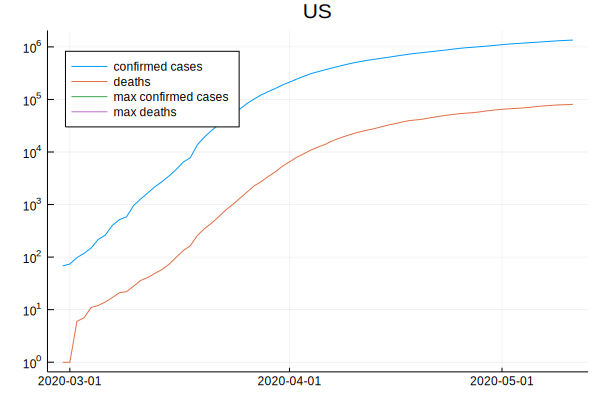

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [49]:
# log raw plot starting with first death
si = findfirst(x->x=="US", countries)
di = findfirst(x->x==countryreports.death1[si], gdatelist)
@time plot(gdatelist[di:end], logprotect(countryconfirm["US"][di:end]), title="US", label="confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(gdatelist[di:end], logprotect(countrydeath["US"][di:end]), title="US", label="deaths")
vline!([countryreports.maxnewconfirm[si]], label="max confirmed cases")
vline!([countryreports.maxnewdeath[si]], label="max deaths")

  0.002157 seconds (8.71 k allocations: 250.711 KiB)
  0.019993 seconds (32.91 k allocations: 1.660 MiB)


GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


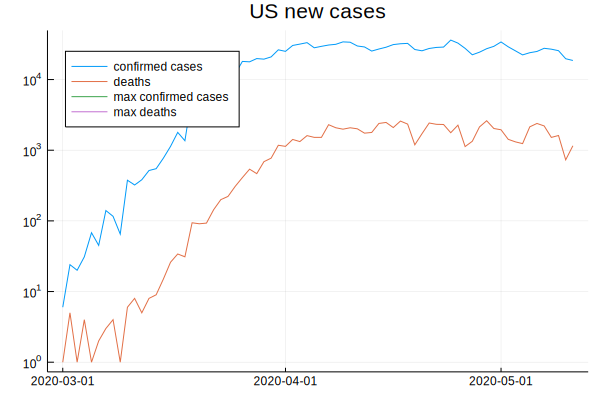

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [50]:
# log new cases plot starting with first death
si = findfirst(x->x=="US", countries)
di = findfirst(x->x==countryreports.death1[si], gdatelist)
@time p = plot(gdatelist[di+1:end], logprotect(newcases(countryconfirm["US"][di:end])), title="US new cases", label="confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(p, gdatelist[di+1:end], logprotect(newcases(countrydeath["US"][di:end])), label="deaths")
vline!(p, [countryreports.maxnewconfirm[si]], label="max confirmed cases")
vline!(p, [countryreports.maxnewdeath[si]], label="max deaths")
savefig(p, "USnewcases.png")
p

In [51]:
countryreports

187×11 DataFrame. Omitted printing of 6 columns
│ Row │ country                  │ confirm1   │ confirm2   │ confirm5   │ confirmlast │
│     │ String                   │ Date       │ Date       │ Date       │ Int64       │
├─────┼──────────────────────────┼────────────┼────────────┼────────────┼─────────────┤
│ 1   │ Afghanistan              │ 2020-02-24 │ 2020-03-08 │ 2020-03-10 │ 4687        │
│ 2   │ Albania                  │ 2020-03-09 │ 2020-03-09 │ 2020-03-10 │ 872         │
│ 3   │ Algeria                  │ 2020-02-25 │ 2020-03-02 │ 2020-03-03 │ 5891        │
│ 4   │ Andorra                  │ 2020-03-02 │ 2020-03-16 │ 2020-03-17 │ 755         │
│ 5   │ Angola                   │ 2020-03-20 │ 2020-03-21 │ 2020-03-28 │ 45          │
│ 6   │ Antigua and Barbuda      │ 2020-03-13 │ 2020-03-23 │ 2020-03-26 │ 25          │
│ 7   │ Argentina                │ 2020-03-03 │ 2020-03-06 │ 2020-03-07 │ 6278        │
│ 8   │ Armenia                  │ 2020-03-01 │ 2020-03-12 │ 2020-03-13 │ 3392        │
│ 9   │ Australia                │ 2020-01-26 │ 2020-01-26 │ 2020-01-27 │ 6970        │
│ 10  │ Austria                  │ 2020-02-25 │ 2020-02-25 │ 2020-02-29 │ 15882       │
│ 11  │ Azerbaijan               │ 2020-03-01 │ 2020-03-01 │ 2020-03-05 │ 2589        │
│ 12  │ Bahamas                  │ 2020-03-16 │ 2020-03-19 │ 2020-03-24 │ 93          │
│ 13  │ Bahrain                  │ 2020-02-24 │ 2020-02-25 │ 2020-02-25 │ 5236        │
│ 14  │ Bangladesh               │ 2020-03-08 │ 2020-03-08 │ 2020-03-15 │ 15691       │
│ 15  │ Barbados                 │ 2020-03-17 │ 2020-03-17 │ 2020-03-19 │ 84          │
│ 16  │ Belarus                  │ 2020-02-28 │ 2020-03-04 │ 2020-03-04 │ 23906       │
│ 17  │ Belgium                  │ 2020-02-04 │ 2020-03-01 │ 2020-03-02 │ 53449       │
│ 18  │ Benin                    │ 2020-03-16 │ 2020-03-18 │ 2020-03-23 │ 319         │
│ 19  │ Bhutan                   │ 2020-03-06 │ 2020-03-20 │ 2020-04-02 │ 9           │
│ 20  │ Bolivia                  │ 2020-03-11 │ 2020-03-11 │ 2020-03-14 │ 2831        │
│ 21  │ Bosnia and Herzegovina   │ 2020-03-05 │ 2020-03-05 │ 2020-03-10 │ 2141        │
│ 22  │ Brazil                   │ 2020-02-26 │ 2020-02-29 │ 2020-03-06 │ 169594      │
│ 23  │ Brunei                   │ 2020-03-09 │ 2020-03-11 │ 2020-03-11 │ 141         │
│ 24  │ Bulgaria                 │ 2020-03-08 │ 2020-03-08 │ 2020-03-11 │ 1990        │
│ 25  │ Burkina Faso             │ 2020-03-10 │ 2020-03-11 │ 2020-03-16 │ 760         │
│ 26  │ Cabo Verde               │ 2020-03-20 │ 2020-03-21 │ 2020-03-27 │ 260         │
│ 27  │ Cambodia                 │ 2020-01-27 │ 2020-03-08 │ 2020-03-13 │ 122         │
│ 28  │ Cameroon                 │ 2020-03-06 │ 2020-03-08 │ 2020-03-17 │ 2689        │
│ 29  │ Canada                   │ 2020-01-26 │ 2020-01-28 │ 2020-02-05 │ 71264       │
│ 30  │ Central African Republic │ 2020-03-15 │ 2020-03-20 │ 2020-04-03 │ 143         │
│ 31  │ Chad                     │ 2020-03-19 │ 2020-03-24 │ 2020-03-30 │ 322         │
⋮
│ 156 │ Uruguay                  │ 2020-03-13 │ 2020-03-13 │ 2020-03-14 │ 711         │
│ 157 │ US                       │ 2020-01-22 │ 2020-01-24 │ 2020-01-26 │ 1347881     │
│ 158 │ Uzbekistan               │ 2020-03-15 │ 2020-03-16 │ 2020-03-16 │ 2486        │
│ 159 │ Venezuela                │ 2020-03-14 │ 2020-03-14 │ 2020-03-15 │ 422         │
│ 160 │ Vietnam                  │ 2020-01-23 │ 2020-01-23 │ 2020-02-01 │ 288         │
│ 161 │ Zambia                   │ 2020-03-18 │ 2020-03-18 │ 2020-03-25 │ 267         │
│ 162 │ Zimbabwe                 │ 2020-03-20 │ 2020-03-21 │ 2020-03-27 │ 36          │
│ 163 │ Dominica                 │ 2020-03-22 │ 2020-03-23 │ 2020-03-25 │ 16          │
│ 164 │ Grenada                  │ 2020-03-22 │ 2020-03-26 │ 2020-03-26 │ 21          │
│ 165 │ Mozambique               │ 2020-03-22 │ 2020-03-24 │ 2020-03-25 │ 103         │
│ 166 │ Syria                    │ 2020-03-22 │ 2020-03-25 │ 2020-03-25 │ 47  

## US state reports

In [52]:
names(statereports)

12-element Array{Symbol,1}:
 :state
 :confirm1
 :confirm2
 :confirm5
 :confirmlast
 :death1
 :death2
 :death5
 :deathlast
 :pop
 :maxnewconfirm
 :maxnewdeath

In [53]:
# which States have most recent peak level of new death cases?
sort(statereports[:, [:state, :maxnewdeath]], :maxnewdeath, rev=true)

58×2 DataFrame
│ Row │ state                    │ maxnewdeath │
│     │ String                   │ Date        │
├─────┼──────────────────────────┼─────────────┤
│ 1   │ Arizona                  │ 2020-05-08  │
│ 2   │ Missouri                 │ 2020-05-08  │
│ 3   │ New Hampshire            │ 2020-05-07  │
│ 4   │ Alabama                  │ 2020-05-06  │
│ 5   │ Indiana                  │ 2020-05-06  │
│ 6   │ Minnesota                │ 2020-05-06  │
│ 7   │ North Dakota             │ 2020-05-06  │
│ 8   │ South Dakota             │ 2020-05-06  │
│ 9   │ Illinois                 │ 2020-05-05  │
│ 10  │ Iowa                     │ 2020-05-05  │
│ 11  │ Mississippi              │ 2020-05-05  │
│ 12  │ North Carolina           │ 2020-05-05  │
│ 13  │ Pennsylvania             │ 2020-05-05  │
│ 14  │ Utah                     │ 2020-05-05  │
│ 15  │ District of Columbia     │ 2020-05-04  │
│ 16  │ Arkansas                 │ 2020-05-02  │
│ 17  │ Maryland                 │ 2020-05-02  │
│ 18  │ Nebraska                 │ 2020-04-30  │
│ 19  │ New Jersey               │ 2020-04-30  │
│ 20  │ Texas                    │ 2020-04-30  │
│ 21  │ Ohio                     │ 2020-04-29  │
│ 22  │ South Carolina           │ 2020-04-29  │
│ 23  │ New Mexico               │ 2020-04-27  │
│ 24  │ Delaware                 │ 2020-04-26  │
│ 25  │ Colorado                 │ 2020-04-24  │
│ 26  │ Virgin Islands           │ 2020-04-23  │
│ 27  │ Florida                  │ 2020-04-23  │
│ 28  │ Maine                    │ 2020-04-23  │
│ 29  │ Virginia                 │ 2020-04-23  │
│ 30  │ Grand Princess           │ 2020-04-23  │
│ 31  │ California               │ 2020-04-22  │
│ 32  │ Michigan                 │ 2020-04-22  │
│ 33  │ Wyoming                  │ 2020-04-22  │
│ 34  │ Oklahoma                 │ 2020-04-21  │
│ 35  │ Connecticut              │ 2020-04-20  │
│ 36  │ West Virginia            │ 2020-04-20  │
│ 37  │ Massachusetts            │ 2020-04-19  │
│ 38  │ Rhode Island             │ 2020-04-17  │
│ 39  │ Vermont                  │ 2020-04-16  │
│ 40  │ Hawaii                   │ 2020-04-15  │
│ 41  │ Louisiana                │ 2020-04-14  │
│ 42  │ Tennessee                │ 2020-04-14  │
│ 43  │ Idaho                    │ 2020-04-12  │
│ 44  │ Kansas                   │ 2020-04-11  │
│ 45  │ Puerto Rico              │ 2020-04-09  │
│ 46  │ Oregon                   │ 2020-04-09  │
│ 47  │ Georgia                  │ 2020-04-07  │
│ 48  │ Kentucky                 │ 2020-04-07  │
│ 49  │ Nevada                   │ 2020-04-07  │
│ 50  │ New York                 │ 2020-04-07  │
│ 51  │ Washington               │ 2020-04-06  │
│ 52  │ Wisconsin                │ 2020-04-05  │
│ 53  │ Northern Mariana Islands │ 2020-04-04  │
│ 54  │ Alaska                   │ 2020-04-04  │
│ 55  │ Guam                     │ 2020-04-01  │
│ 56  │ Montana                  │ 2020-03-30  │
│ 57  │ American Samoa           │ 2020-03-17  │
│ 58  │ Diamond Princess         │ 2020-03-17  │

In [54]:
# which States are still close to peak level of new confirmed cases?
sort(statereports[:, [:state, :maxnewconfirm]], :maxnewconfirm, rev=true)

58×2 DataFrame
│ Row │ state                    │ maxnewconfirm │
│     │ String                   │ Date          │
├─────┼──────────────────────────┼───────────────┤
│ 1   │ California               │ 2020-05-09    │
│ 2   │ South Dakota             │ 2020-05-09    │
│ 3   │ Arizona                  │ 2020-05-08    │
│ 4   │ Mississippi              │ 2020-05-08    │
│ 5   │ Maine                    │ 2020-05-07    │
│ 6   │ Minnesota                │ 2020-05-07    │
│ 7   │ Kentucky                 │ 2020-05-05    │
│ 8   │ Puerto Rico              │ 2020-05-02    │
│ 9   │ Iowa                     │ 2020-05-02    │
│ 10  │ District of Columbia     │ 2020-05-01    │
│ 11  │ Illinois                 │ 2020-05-01    │
│ 12  │ Maryland                 │ 2020-05-01    │
│ 13  │ Nebraska                 │ 2020-05-01    │
│ 14  │ Tennessee                │ 2020-05-01    │
│ 15  │ Virginia                 │ 2020-05-01    │
│ 16  │ Wisconsin                │ 2020-05-01    │
│ 17  │ Kansas                   │ 2020-04-30    │
│ 18  │ North Carolina           │ 2020-04-30    │
│ 19  │ Texas                    │ 2020-04-30    │
│ 20  │ Indiana                  │ 2020-04-27    │
│ 21  │ Alabama                  │ 2020-04-26    │
│ 22  │ Delaware                 │ 2020-04-26    │
│ 23  │ New Mexico               │ 2020-04-25    │
│ 24  │ Colorado                 │ 2020-04-24    │
│ 25  │ Massachusetts            │ 2020-04-24    │
│ 26  │ Arkansas                 │ 2020-04-23    │
│ 27  │ Pennsylvania             │ 2020-04-23    │
│ 28  │ Connecticut              │ 2020-04-22    │
│ 29  │ Wyoming                  │ 2020-04-21    │
│ 30  │ Ohio                     │ 2020-04-19    │
│ 31  │ West Virginia            │ 2020-04-19    │
│ 32  │ North Dakota             │ 2020-04-18    │
│ 33  │ Georgia                  │ 2020-04-17    │
│ 34  │ Nevada                   │ 2020-04-17    │
│ 35  │ Rhode Island             │ 2020-04-17    │
│ 36  │ New Hampshire            │ 2020-04-15    │
│ 37  │ New York                 │ 2020-04-15    │
│ 38  │ Missouri                 │ 2020-04-10    │
│ 39  │ Utah                     │ 2020-04-10    │
│ 40  │ South Carolina           │ 2020-04-09    │
│ 41  │ Guam                     │ 2020-04-05    │
│ 42  │ Oregon                   │ 2020-04-05    │
│ 43  │ Oklahoma                 │ 2020-04-04    │
│ 44  │ Vermont                  │ 2020-04-04    │
│ 45  │ Hawaii                   │ 2020-04-03    │
│ 46  │ Michigan                 │ 2020-04-03    │
│ 47  │ New Jersey               │ 2020-04-03    │
│ 48  │ Florida                  │ 2020-04-02    │
│ 49  │ Idaho                    │ 2020-04-02    │
│ 50  │ Louisiana                │ 2020-04-02    │
│ 51  │ Montana                  │ 2020-04-02    │
│ 52  │ Washington               │ 2020-04-02    │
│ 53  │ Northern Mariana Islands │ 2020-04-01    │
│ 54  │ Alaska                   │ 2020-03-28    │
│ 55  │ Grand Princess           │ 2020-03-28    │
│ 56  │ Virgin Islands           │ 2020-03-24    │
│ 57  │ American Samoa           │ 2020-03-17    │
│ 58  │ Diamond Princess         │ 2020-03-17    │

In [55]:
# which States have had the most deaths?
sort(statereports[:, [:state, :deathlast]], :deathlast, rev=true)

58×2 DataFrame
│ Row │ state                    │ deathlast │
│     │ String                   │ Int64     │
├─────┼──────────────────────────┼───────────┤
│ 1   │ New York                 │ 26988     │
│ 2   │ New Jersey               │ 9340      │
│ 3   │ Massachusetts            │ 5108      │
│ 4   │ Michigan                 │ 4584      │
│ 5   │ Pennsylvania             │ 3832      │
│ 6   │ Illinois                 │ 3459      │
│ 7   │ Connecticut              │ 3008      │
│ 8   │ California               │ 2779      │
│ 9   │ Louisiana                │ 2308      │
│ 10  │ Florida                  │ 1735      │
│ 11  │ Maryland                 │ 1683      │
│ 12  │ Indiana                  │ 1540      │
│ 13  │ Georgia                  │ 1444      │
│ 14  │ Ohio                     │ 1357      │
│ 15  │ Texas                    │ 1117      │
│ 16  │ Colorado                 │ 987       │
│ 17  │ Washington               │ 945       │
│ 18  │ Virginia                 │ 850       │
│ 19  │ Minnesota                │ 591       │
│ 20  │ North Carolina           │ 575       │
│ 21  │ Arizona                  │ 542       │
│ 22  │ Missouri                 │ 514       │
│ 23  │ Mississippi              │ 435       │
│ 24  │ Rhode Island             │ 430       │
│ 25  │ Wisconsin                │ 409       │
│ 26  │ Alabama                  │ 403       │
│ 27  │ South Carolina           │ 346       │
│ 28  │ District of Columbia     │ 328       │
│ 29  │ Nevada                   │ 312       │
│ 30  │ Kentucky                 │ 311       │
│ 31  │ Oklahoma                 │ 274       │
│ 32  │ Iowa                     │ 271       │
│ 33  │ Tennessee                │ 251       │
│ 34  │ Delaware                 │ 225       │
│ 35  │ New Mexico               │ 208       │
│ 36  │ Kansas                   │ 180       │
│ 37  │ New Hampshire            │ 133       │
│ 38  │ Oregon                   │ 130       │
│ 39  │ Puerto Rico              │ 113       │
│ 40  │ Nebraska                 │ 98        │
│ 41  │ Arkansas                 │ 94        │
│ 42  │ Idaho                    │ 70        │
│ 43  │ Utah                     │ 68        │
│ 44  │ Maine                    │ 65        │
│ 45  │ West Virginia            │ 54        │
│ 46  │ Vermont                  │ 53        │
│ 47  │ North Dakota             │ 36        │
│ 48  │ South Dakota             │ 34        │
│ 49  │ Hawaii                   │ 17        │
│ 50  │ Montana                  │ 16        │
│ 51  │ Alaska                   │ 10        │
│ 52  │ Wyoming                  │ 7         │
│ 53  │ Guam                     │ 5         │
│ 54  │ Virgin Islands           │ 5         │
│ 55  │ Grand Princess           │ 3         │
│ 56  │ Northern Mariana Islands │ 2         │
│ 57  │ American Samoa           │ 0         │
│ 58  │ Diamond Princess         │ 0         │

In [56]:
statereports.deathlast./statereports.pop * 100000

58-element Array{Float64,1}:
   0.0
   3.0445292853271955
   3.626867836936022
   3.8521746719174423
   4.661222358951411
   8.219147350140776
   1.366969906157516
   7.446367265000137
   3.1148477502183707
   7.033266642577919
  17.139177764009325
  84.36908445238771
  23.106214647491587
  46.47544665313022
   8.078132253877586
  13.600286999962231
   1.2006735072096912
   3.9170371530973975
  27.296787099502115
  22.87507284002496
   8.589349840098635
   6.178530704208335
   6.961118237614973
  49.64728486570926
   4.835546773871979
  27.83805957311667
  74.10950709778436
  45.900326799512605
  10.479407166992457
  14.616203691414643
   7.756885329843439
   1.4970368027785004
   5.066149436933677
  10.129357084511303
   9.781490331401304
 105.15424686929687
   9.919740713238895
 114.22010223858787
   5.482412230870767
   4.724025079324255
  11.609105919189673
   6.9244884534155045
   3.0822215799610078
  29.93284871593
  40.590506918793494
   6.72012467579283
   3.843288770023252
   

In [57]:
# slightly different if we factor in population (deaths per 100,000)
ds = statereports.deathlast./statereports.pop * 100000
@time sortslices(hcat(statereports.state, ds), dims=1, lt=(x,y)->isless(x[2],y[2]), rev=true)

  0.996328 seconds (2.84 M allocations: 144.732 MiB, 5.93% gc time)


58×2 Array{Any,2}:
 "Diamond Princess"          NaN
 "Grand Princess"             Inf
 "New York"                  114.22
 "New Jersey"                105.154
 "Connecticut"                84.3691
 "Massachusetts"              74.1095
 "Louisiana"                  49.6473
 "District of Columbia"       46.4754
 "Michigan"                   45.9003
 "Rhode Island"               40.5905
 "Pennsylvania"               29.9328
 "Maryland"                   27.8381
 "Illinois"                   27.2968
 "Delaware"                   23.1062
 "Indiana"                    22.8751
 "Colorado"                   17.1392
 "Mississippi"                14.6162
 "Georgia"                    13.6003
 "Washington"                 12.4099
 "Ohio"                       11.6091
 "Minnesota"                  10.4794
 "Nevada"                     10.1294
 "Virginia"                    9.95839
 "New Mexico"                  9.91974
 "New Hampshire"               9.78149
 "Iowa"                        8.58935
 

In [58]:
# for total US current death rate per 100,000
sum(statereports.deathlast)/sum(statereports.pop) * 100000

23.99688345673616

## plot confirmed

  0.236665 seconds (865.72 k allocations: 35.749 MiB)
  0.392073 seconds (296.41 k allocations: 15.322 MiB, 5.77% gc time)


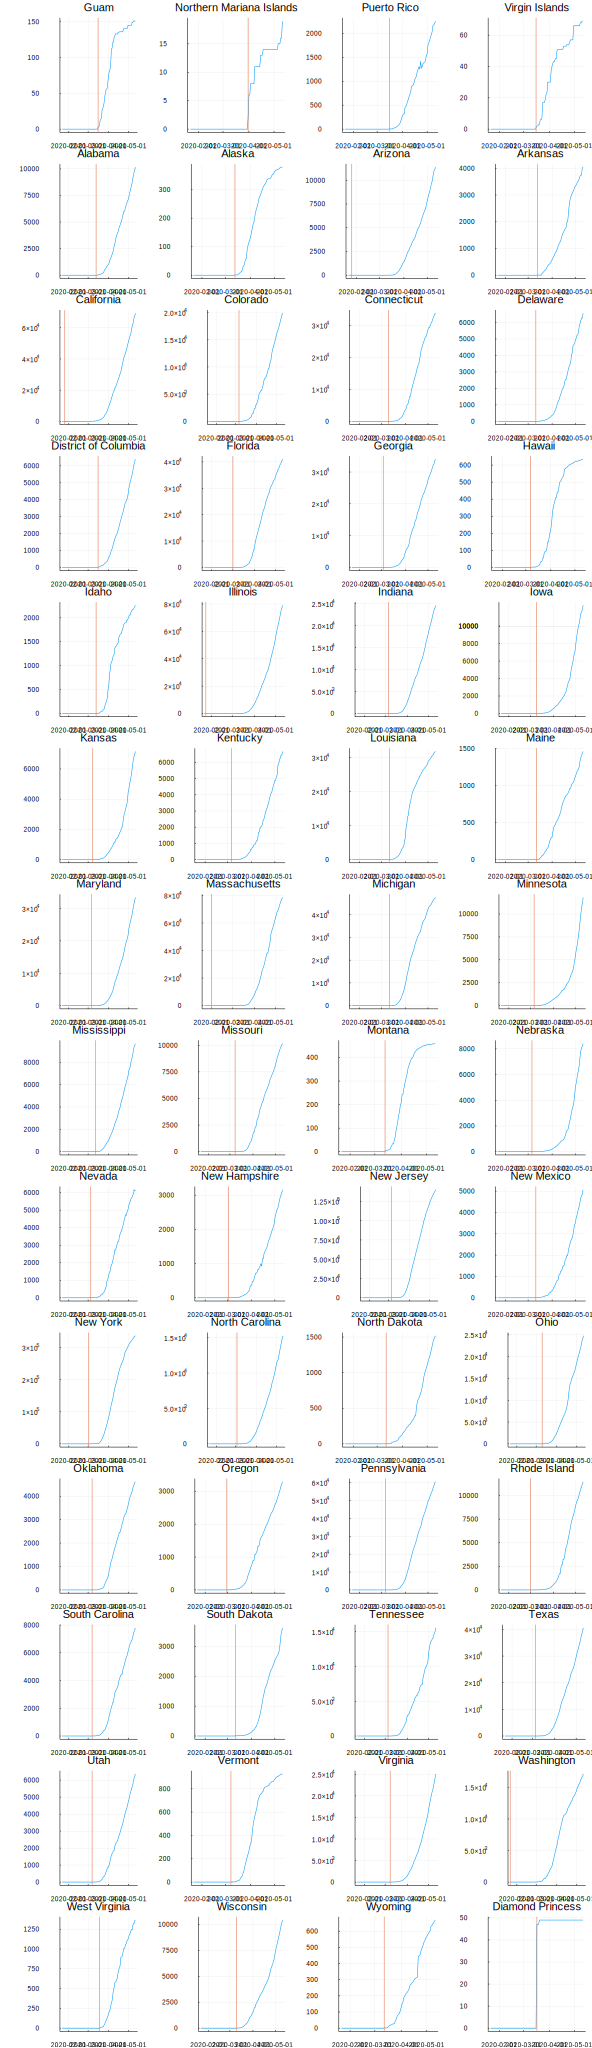

In [59]:
# raw plot with date of first confirmed diagnosis
p = []
@time for i = 2:57
    pi = plot(datelist, stateconfirm[states[i]], title=states[i], legend=false)
    pi = vline!([statereports.confirm1[i]])
    push!(p, pi)
end
@time plot(p..., size=(1100,3800), layout=(14,4), left_margin=50px)

  0.136538 seconds (660.24 k allocations: 23.064 MiB)
  0.683987 seconds (366.67 k allocations: 18.531 MiB)


GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine PO

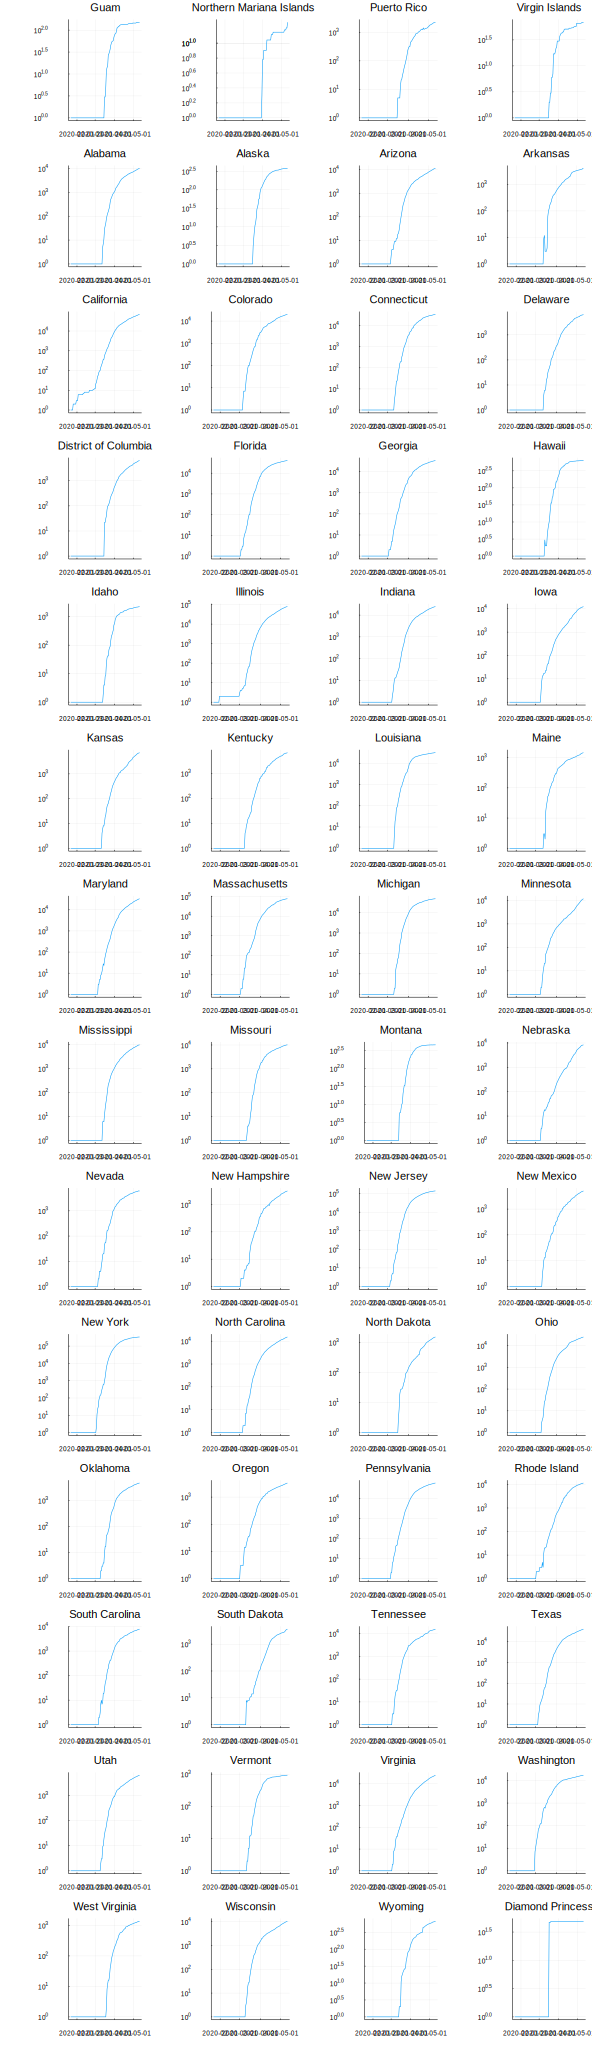

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine PO

In [60]:
# raw plot is hard to see rate, so let's log scale it to see if we are "flattening the curve"
p = []
@time for i = 2:57
    pi = plot(datelist, logprotect(stateconfirm[states[i]]), title=states[i], legend=false, yaxis=:log)
    pi = vline!([statereports.confirm1[i]])
    push!(p, pi)
end
@time savefig(plot(p..., size=(3000,2400), layout=(7,8), left_margin=50px), "allconfirm.png")
plot(p..., size=(1100,3800), layout=(14,4), left_margin=50px)

## new confirm

  0.089204 seconds (597.86 k allocations: 20.019 MiB)
  0.006949 seconds (28.85 k allocations: 2.271 MiB)


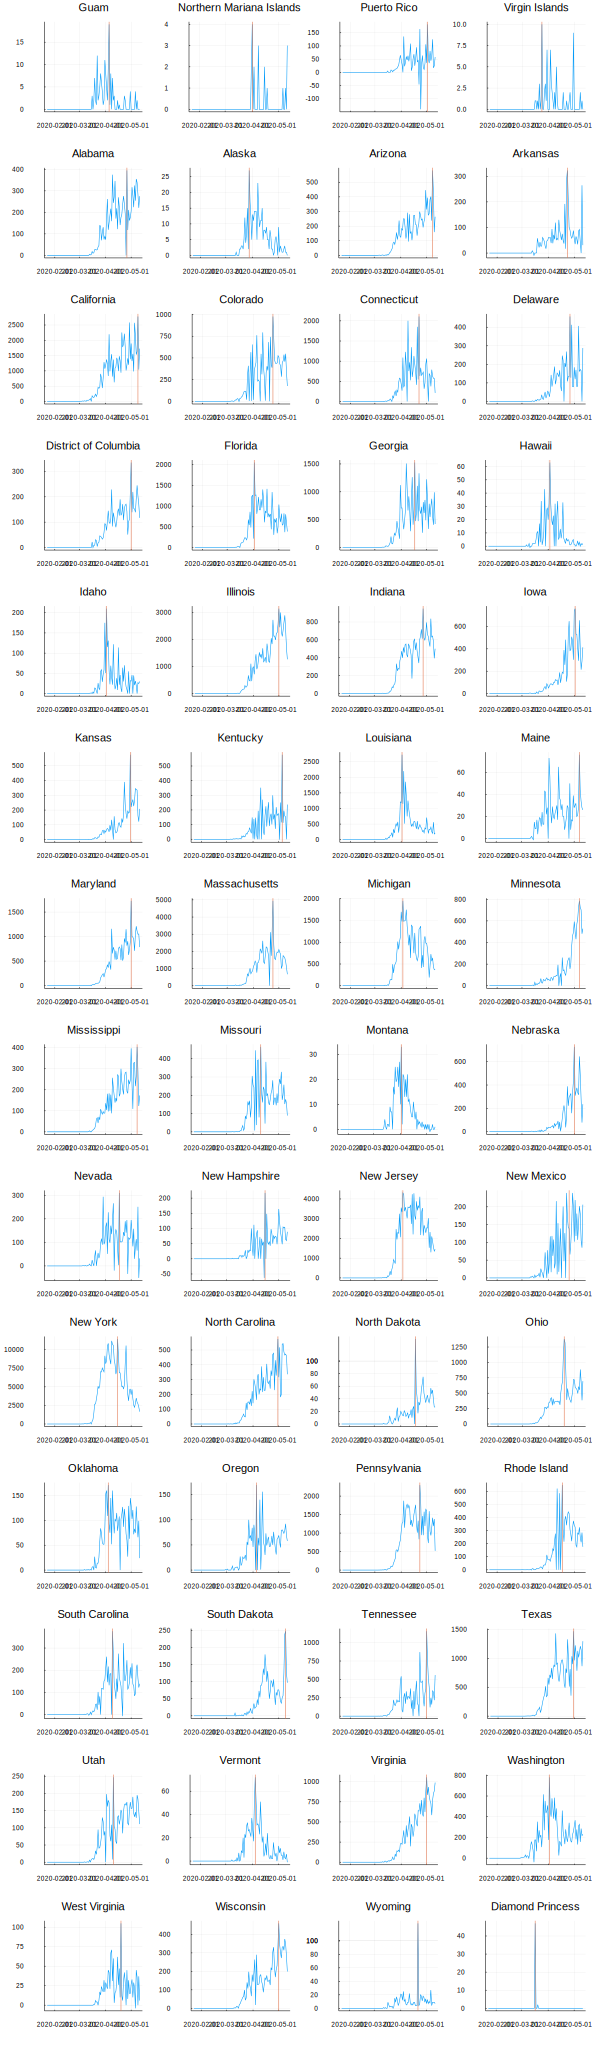

In [61]:
# I think it is a lot easier to see if we plot newcases to see if heading back down to zero
p = []
@time for i = 2:57
    pi = plot(datelist[2:end], newcases(stateconfirm[states[i]]), title=states[i], legend=false)
    pi = vline!([statereports.maxnewconfirm[i]])
    push!(p, pi)
end
@time plot(p..., size=(1100,3800), layout=(14,4), left_margin=50px)

  0.449295 seconds (1.32 M allocations: 54.179 MiB)
  0.741803 seconds (374.36 k allocations: 19.233 MiB, 3.97% gc time)
  0.006984 seconds (28.51 k allocations: 1.766 MiB)


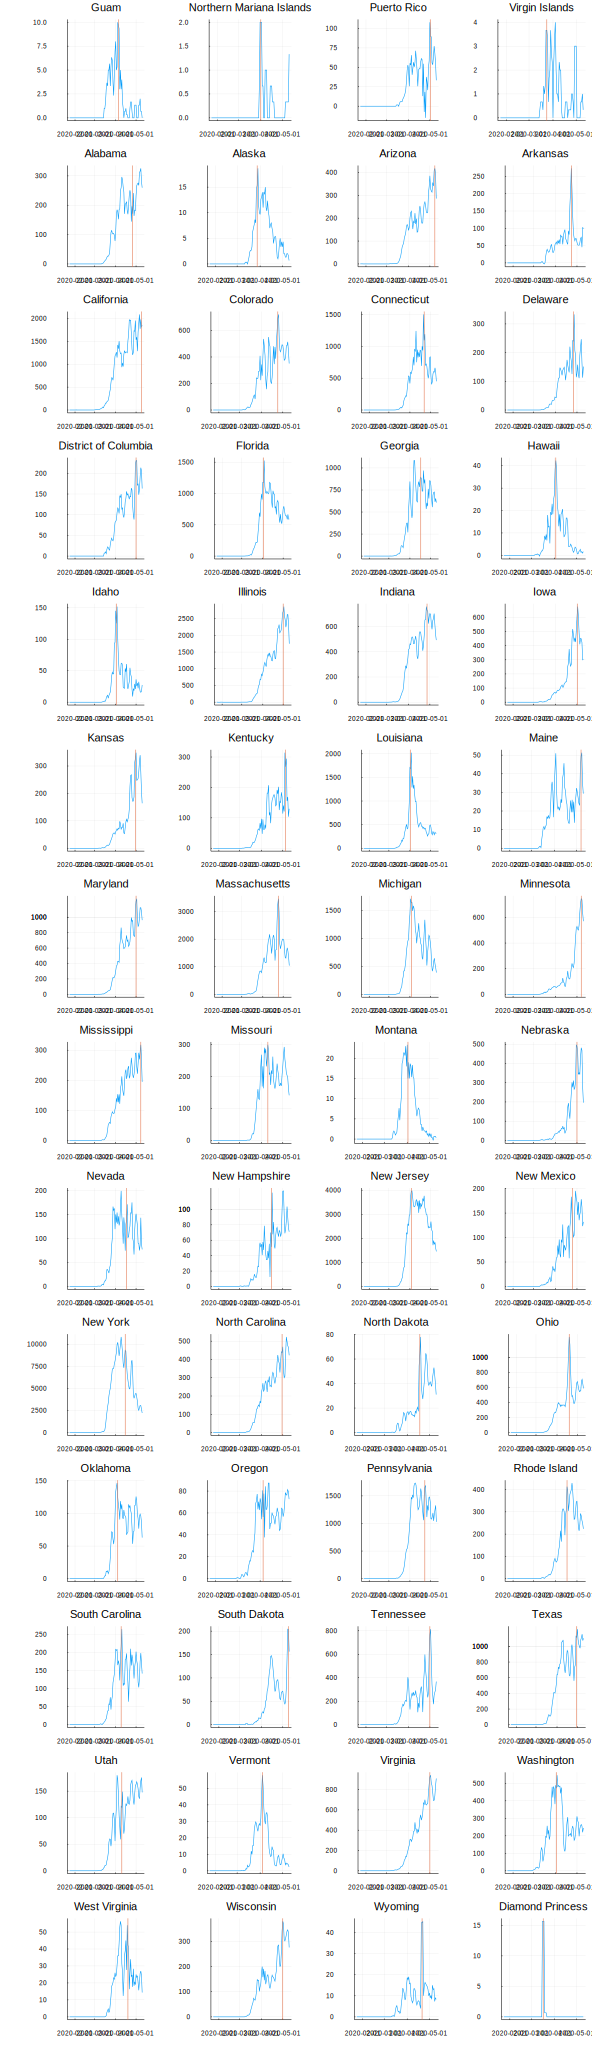

In [62]:
# daily newcasesis pretty jagged, so let's smooth a little
p = []
@time for i = 2:57
    pi = plot(datelist[3:end-1], smooth(newcases(stateconfirm[states[i]]),3), title=states[i], legend=false)
    pi = vline!([statereports.maxnewconfirm[i]])
    push!(p, pi)
end
@time savefig(plot(p..., size=(3000,2400), layout=(7,8), left_margin=50px), "allnewconfirm.png")
@time plot(p..., size=(1100,3800), layout=(14,4), left_margin=50px)

## new death

  0.092205 seconds (597.86 k allocations: 20.019 MiB)
  0.006701 seconds (28.85 k allocations: 2.271 MiB)


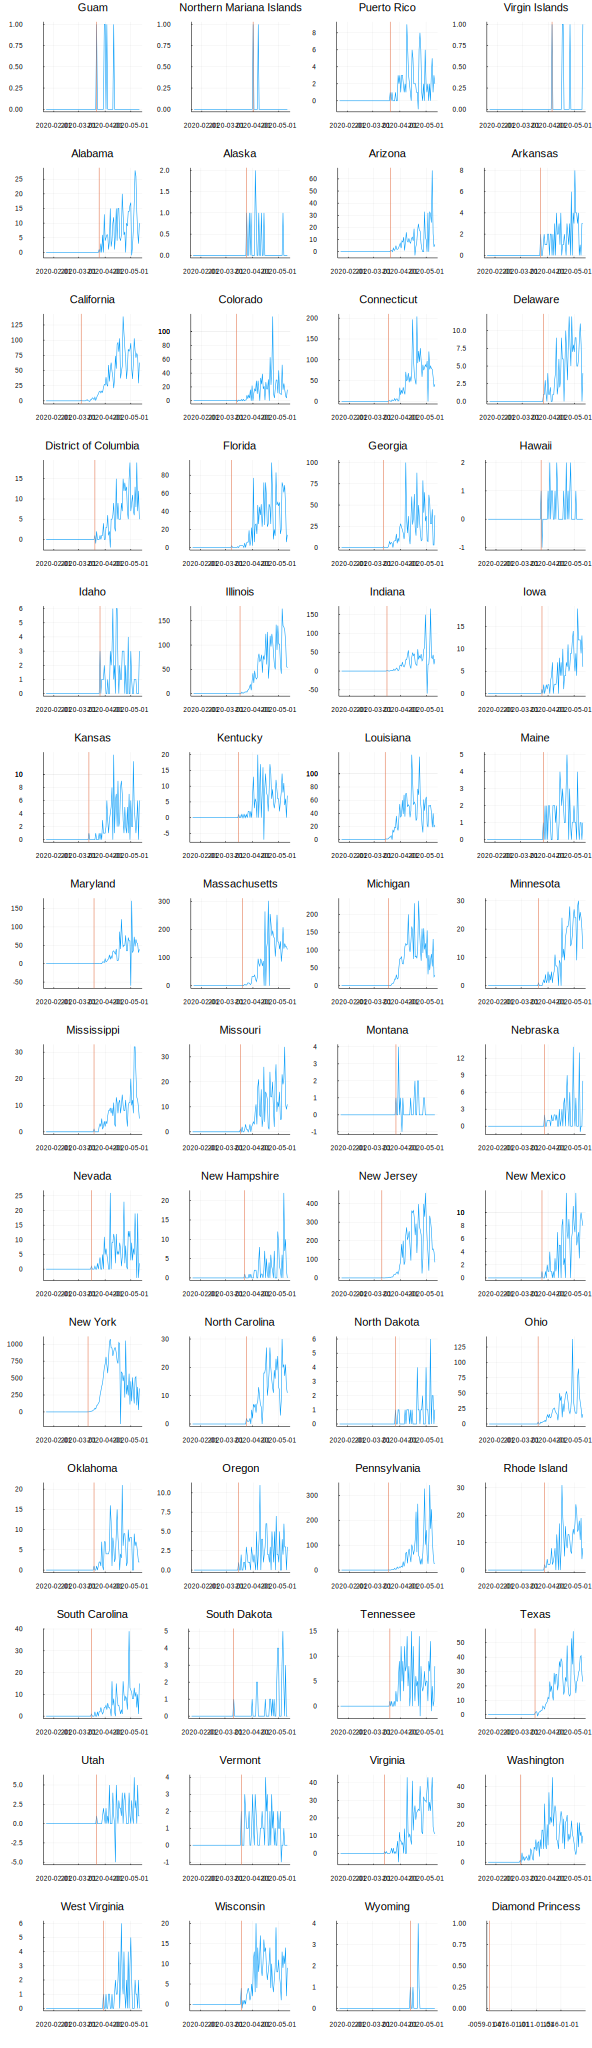

In [63]:
# plot newcases with death1
p = []
@time for i = 2:57
    pi = plot(datelist[2:end], newcases(statedeath[states[i]]), title=states[i], legend=false)
    pi = vline!([statereports.death1[i]])
    push!(p, pi)
end
@time plot(p..., size=(1100,3800), layout=(14,4), left_margin=50px)

  0.092843 seconds (604.30 k allocations: 20.785 MiB)
  0.727759 seconds (380.14 k allocations: 19.591 MiB, 3.21% gc time)
  0.007893 seconds (28.51 k allocations: 1.766 MiB)


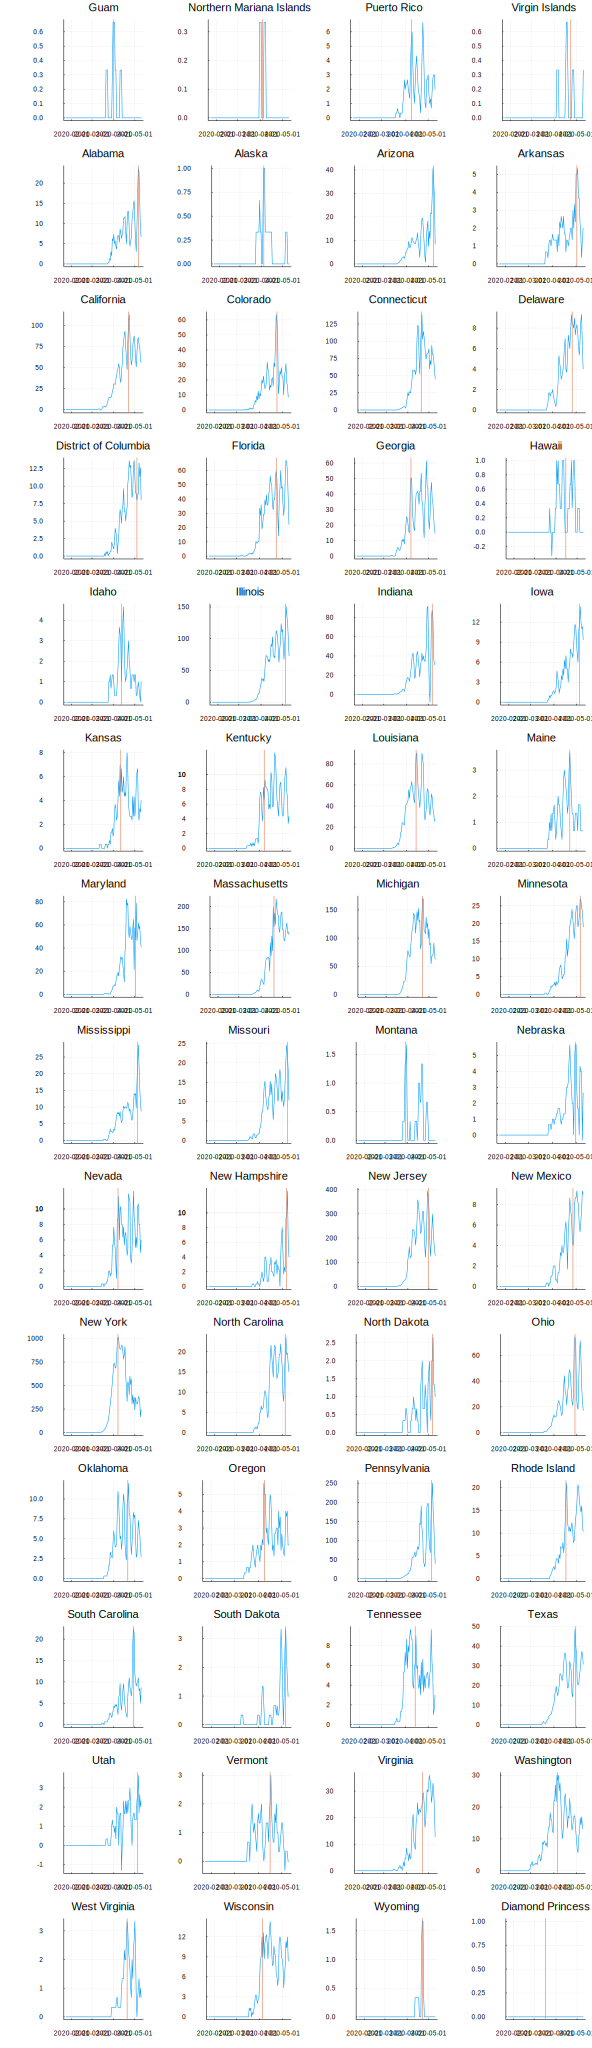

In [64]:
# smooth newcases death
p = []
@time for i = 2:57
    pi = plot(datelist[3:end-1], smooth(newcases(statedeath[states[i]]),3), title=states[i], legend=false)
    pi = vline!([statereports.maxnewdeath[i]])
    push!(p, pi)
end
@time savefig(plot(p..., size=(3000,2400), layout=(7,8), left_margin=50px), "allnewdeath.png")
@time plot(p..., size=(1100,3800), layout=(14,4), left_margin=50px)

## confirm + death plot

In [65]:
states[57]

"Diamond Princess"

  0.004856 seconds (8.79 k allocations: 253.086 KiB)
  0.000641 seconds (1.62 k allocations: 97.789 KiB)


GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


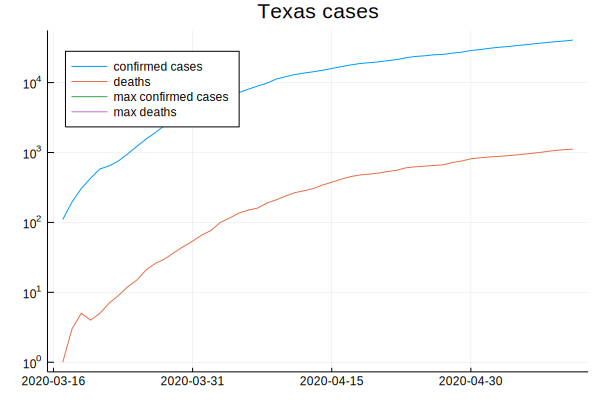

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [66]:
# log new cases plot starting with first death
target = "Texas"
si = findfirst(x->x==target, states)
di = findfirst(x->x==statereports.death1[si], gdatelist)
@time p = plot(gdatelist[di:end], logprotect(stateconfirm[target][di:end]), title=target * " cases", label="confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(p, gdatelist[di:end], logprotect(statedeath[target][di:end]), label="deaths")
vline!(p, [statereports.maxnewconfirm[si]], label="max confirmed cases")
vline!(p, [statereports.maxnewdeath[si]], label="max deaths")
savefig(p, target * "cases.png")
p

  0.001661 seconds (8.71 k allocations: 248.977 KiB)
  0.000711 seconds (1.63 k allocations: 98.930 KiB)


GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


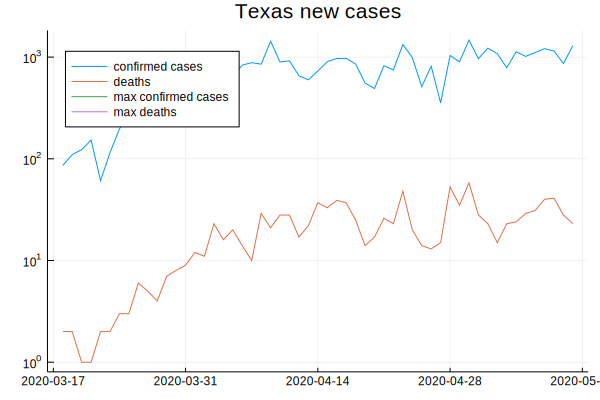

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [67]:
# log new cases plot starting with first death
target = "Texas"
si = findfirst(x->x==target, states)
di = findfirst(x->x==statereports.death1[si], gdatelist)
@time p = plot(gdatelist[di+1:end], logprotect(newcases(stateconfirm[target][di:end])), title=target * " new cases", label="confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(p, gdatelist[di+1:end], logprotect(newcases(statedeath[target][di:end])), label="deaths")
vline!(p, [statereports.maxnewconfirm[si]], label="max confirmed cases")
vline!(p, [statereports.maxnewdeath[si]], label="max deaths")
savefig(p, target * "newcases.png")
p

  0.001086 seconds (8.70 k allocations: 248.602 KiB)
  0.000624 seconds (1.62 k allocations: 98.539 KiB)


GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


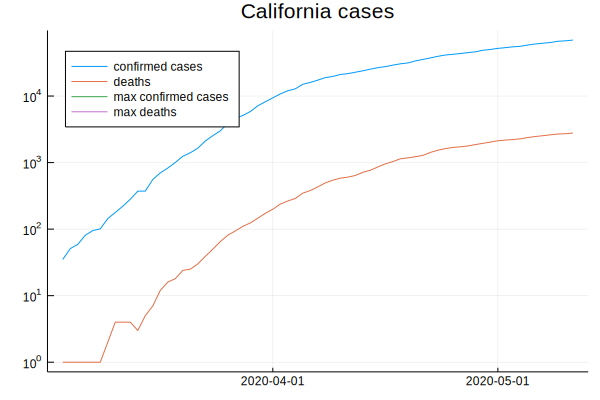

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [68]:
# log new cases plot starting with first death
target = "California"
si = findfirst(x->x==target, states)
di = findfirst(x->x==statereports.death1[si], gdatelist)
@time p = plot(gdatelist[di:end], logprotect(stateconfirm[target][di:end]), title=target * " cases", label="confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(p, gdatelist[di:end], logprotect(statedeath[target][di:end]), label="deaths")
vline!(p, [statereports.maxnewconfirm[si]], label="max confirmed cases")
vline!(p, [statereports.maxnewdeath[si]], label="max deaths")
savefig(p, target * "cases.png")
p

  0.001763 seconds (8.71 k allocations: 250.570 KiB)
  0.000605 seconds (1.63 k allocations: 100.508 KiB)


GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


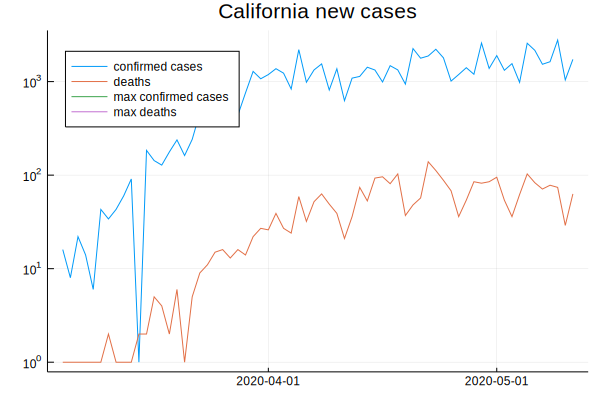

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [69]:
# log new cases plot starting with first death
target = "California"
si = findfirst(x->x==target, states)
di = findfirst(x->x==statereports.death1[si], gdatelist)
@time p = plot(gdatelist[di+1:end], logprotect(newcases(stateconfirm[target][di:end])), title=target * " new cases", label="confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(p, gdatelist[di+1:end], logprotect(newcases(statedeath[target][di:end])), label="deaths")
vline!(p, [statereports.maxnewconfirm[si]], label="max confirmed cases")
vline!(p, [statereports.maxnewdeath[si]], label="max deaths")
savefig(p, target * "newcases.png")
p

  0.214374 seconds (866.50 k allocations: 34.921 MiB)
  0.026445 seconds (52.26 k allocations: 3.971 MiB)


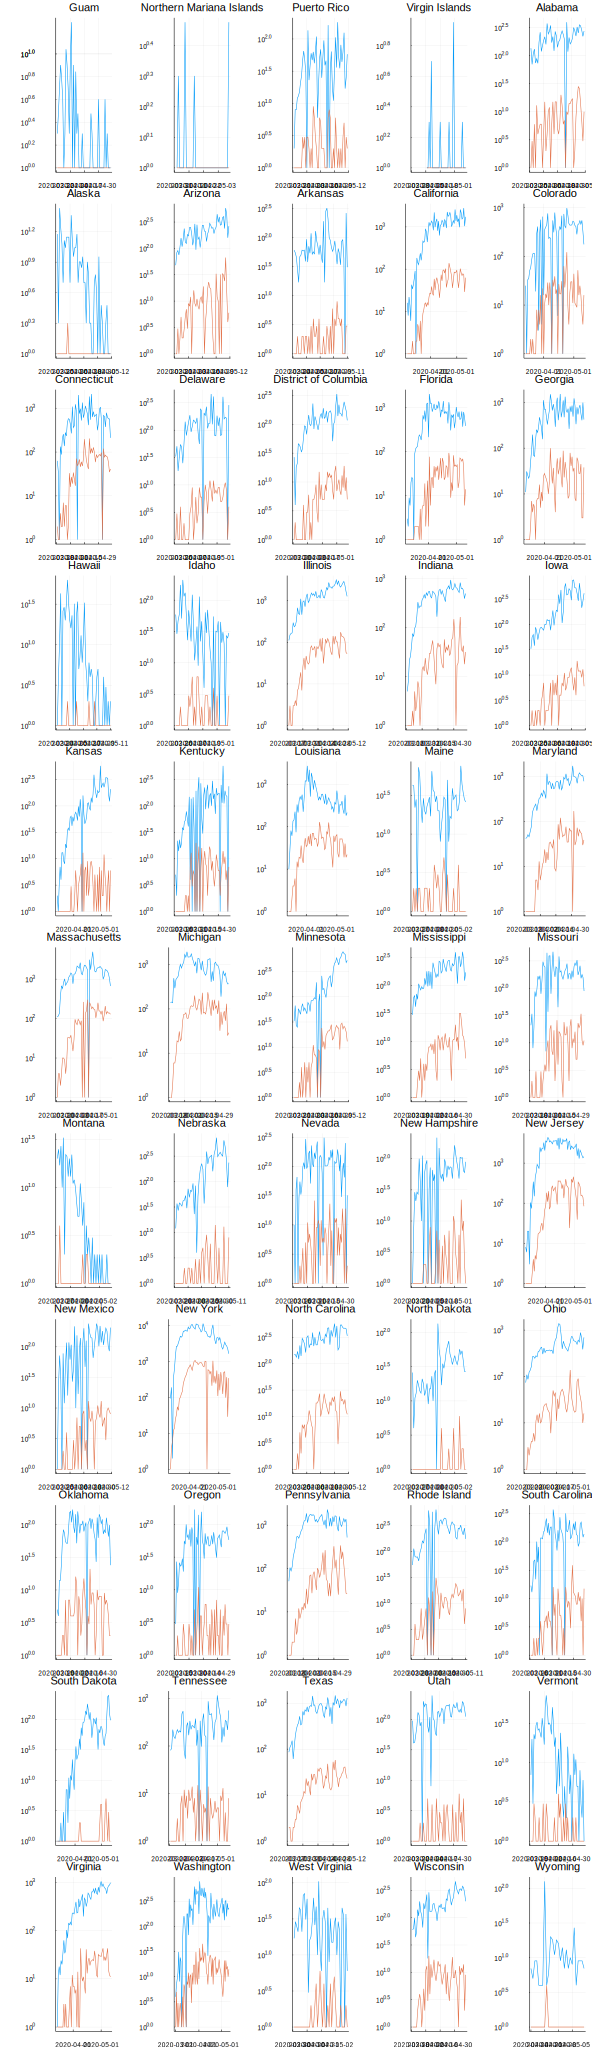

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine PO

In [70]:
# log new cases plot starting with first death
p = []
@time for i = 2:56
    di = findfirst(x->x==statereports.death1[i], datelist)
    pi = plot(datelist[di+1:end], logprotect(newcases(stateconfirm[states[i]][di:end])), title=states[i], label="new confirmed cases", legend=false, yaxis=:log)
    plot!(pi, datelist[di+1:end], logprotect(newcases(statedeath[states[i]][di:end])), title=states[i], label="new deaths")
    vline!(pi, [statereports.maxnewconfirm[i]], label="max new confirmed cases")
    vline!(pi, [statereports.maxnewdeath[i]], label="max new deaths")
    push!(p, pi)
end
@time plot(p..., size=(1100,3800), layout=(11,5), left_margin=50px)

In [71]:
chosen = ["California", "New York", "Florida", "Washington", "Illinois", "Texas"]

6-element Array{String,1}:
 "California"
 "New York"
 "Florida"
 "Washington"
 "Illinois"
 "Texas"

In [72]:
@time ci = [findfirst(x->x==s, states) for s in chosen]

  0.071349 seconds (104.72 k allocations: 5.265 MiB)


6-element Array{Int64,1}:
 10
 38
 15
 53
 19
 49

In [73]:
@time mi = findmin(map(x->statereports.confirm5[x], ci))

  0.156427 seconds (249.00 k allocations: 12.799 MiB, 15.58% gc time)


(2020-02-03, 1)

In [74]:
@time start = ci[mi[2]]

  0.000011 seconds


10

  0.041659 seconds (53.69 k allocations: 2.681 MiB)


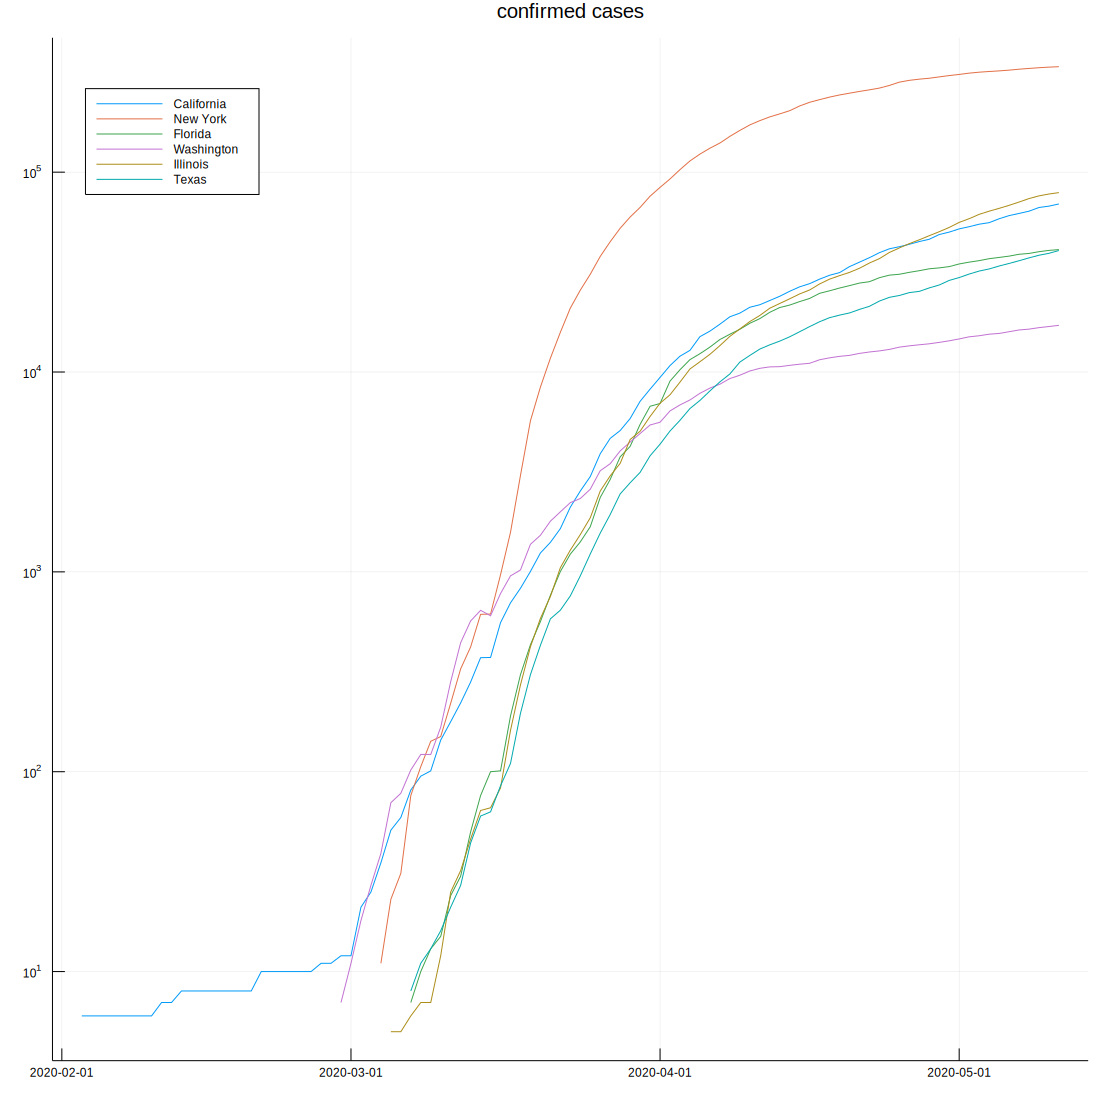

In [75]:
# log plot select confirmed cases
si = findfirst(x->x==statereports.confirm5[start], datelist)
p = plot(datelist[si:end], logprotect(stateconfirm[states[start]][si:end]), label=states[start], yaxis=:log,
    legend=:topleft, size=(1100,1100), title="confirmed cases")
@time for i in vcat(ci[1:mi[2]-1], ci[mi[2]+1:end])
    si = findfirst(x->x==statereports.confirm5[i], datelist)
    plot!(p, datelist[si:end], logprotect(stateconfirm[states[i]][si:end]), label=states[i])
end
savefig(p, "selectconfirm.png")
p

  0.002513 seconds (8.72 k allocations: 581.070 KiB)


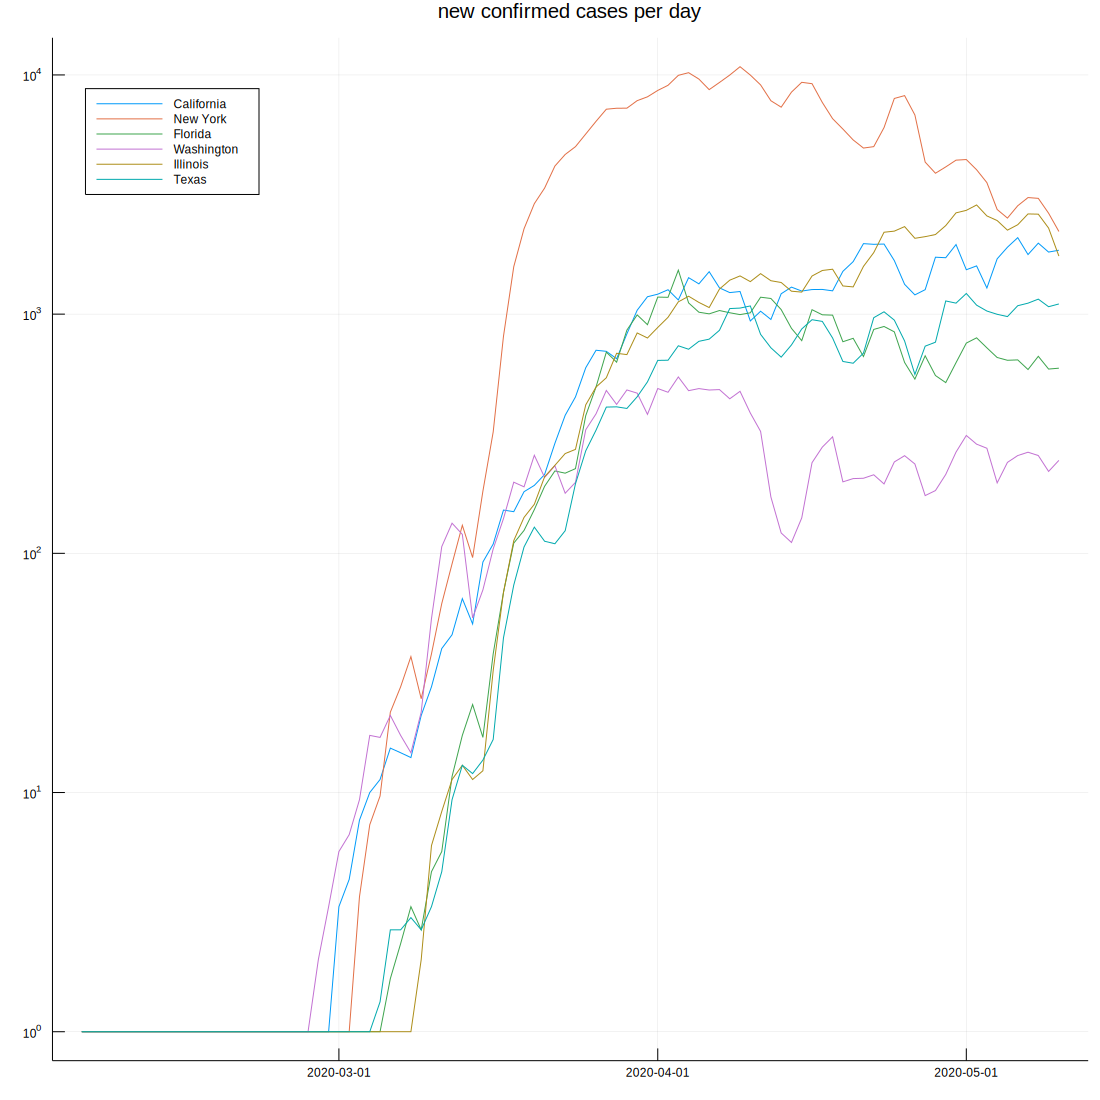

In [76]:
# plot select new cases
si = findfirst(x->x==statereports.confirm5[start], datelist)
p = plot(datelist[si+2:end-1], logprotect(smooth(newcases(stateconfirm[states[start]]), 3)[si:end]), label=states[start], yaxis=:log,
    legend=:topleft, size=(1100,1100), title="new confirmed cases per day")
@time for i in vcat(ci[1:mi[2]-1], ci[mi[2]+1:end])
    plot!(p, datelist[si+2:end-1], logprotect(smooth(newcases(stateconfirm[states[i]]), 3)[si:end]), label=states[i])
end
savefig(p, "selectnewconfirm.png")
p

  0.002612 seconds (8.72 k allocations: 581.070 KiB)


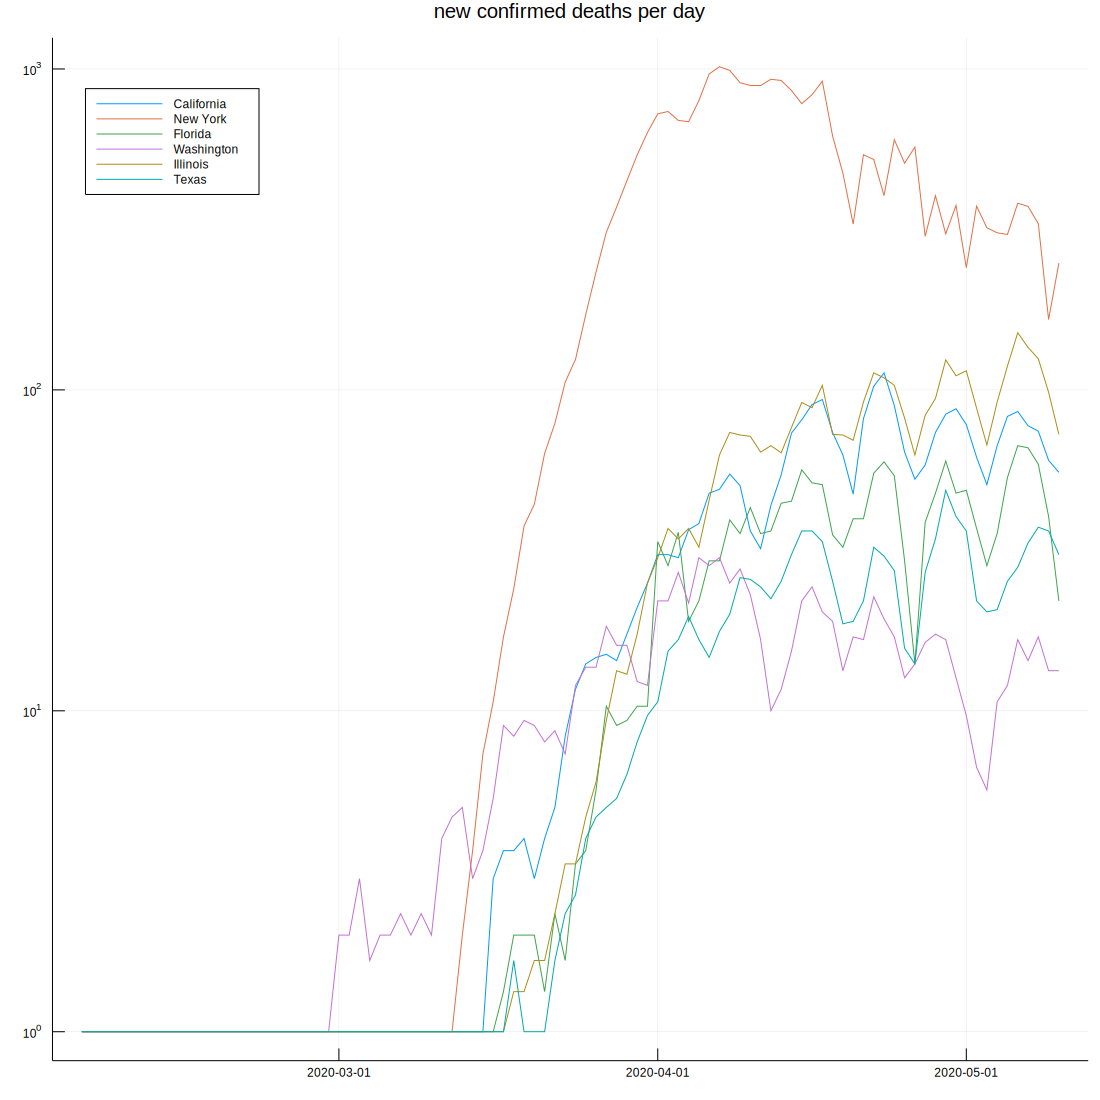

In [77]:
# plot select new deaths
si = findfirst(x->x==statereports.confirm5[start], datelist)
p = plot(datelist[si+2:end-1], logprotect(smooth(newcases(statedeath[states[start]]), 3)[si:end]), label=states[start], yaxis=:log,
    legend=:topleft, size=(1100,1100), title="new confirmed deaths per day")
@time for i in vcat(ci[1:mi[2]-1], ci[mi[2]+1:end])
    plot!(p, datelist[si+2:end-1], logprotect(smooth(newcases(statedeath[states[i]]), 3)[si:end]), label=states[i])
end
savefig(p, "selectnewdeath.png")
p

## County information

In [78]:
target_state = "California"

"California"

In [79]:
usconf[usconf.Province_State .== target_state, :]

60×122 DataFrame. Omitted printing of 115 columns
│ Row │ UID      │ iso2   │ iso3   │ code3 │ FIPS     │ Admin2          │ Province_State │
│     │ Int64    │ String │ String │ Int64 │ Float64⍰ │ String⍰         │ String         │
├─────┼──────────┼────────┼────────┼───────┼──────────┼─────────────────┼────────────────┤
│ 1   │ 84006001 │ US     │ USA    │ 840   │ 6001.0   │ Alameda         │ California     │
│ 2   │ 84006003 │ US     │ USA    │ 840   │ 6003.0   │ Alpine          │ California     │
│ 3   │ 84006005 │ US     │ USA    │ 840   │ 6005.0   │ Amador          │ California     │
│ 4   │ 84006007 │ US     │ USA    │ 840   │ 6007.0   │ Butte           │ California     │
│ 5   │ 84006009 │ US     │ USA    │ 840   │ 6009.0   │ Calaveras       │ California     │
│ 6   │ 84006011 │ US     │ USA    │ 840   │ 6011.0   │ Colusa          │ California     │
│ 7   │ 84006013 │ US     │ USA    │ 840   │ 6013.0   │ Contra Costa    │ California     │
│ 8   │ 84006015 │ US     │ USA    │ 840   │ 6015.0   │ Del Norte       │ California     │
│ 9   │ 84006017 │ US     │ USA    │ 840   │ 6017.0   │ El Dorado       │ California     │
│ 10  │ 84006019 │ US     │ USA    │ 840   │ 6019.0   │ Fresno          │ California     │
│ 11  │ 84006021 │ US     │ USA    │ 840   │ 6021.0   │ Glenn           │ California     │
│ 12  │ 84006023 │ US     │ USA    │ 840   │ 6023.0   │ Humboldt        │ California     │
│ 13  │ 84006025 │ US     │ USA    │ 840   │ 6025.0   │ Imperial        │ California     │
│ 14  │ 84006027 │ US     │ USA    │ 840   │ 6027.0   │ Inyo            │ California     │
│ 15  │ 84006029 │ US     │ USA    │ 840   │ 6029.0   │ Kern            │ California     │
│ 16  │ 84006031 │ US     │ USA    │ 840   │ 6031.0   │ Kings           │ California     │
│ 17  │ 84006033 │ US     │ USA    │ 840   │ 6033.0   │ Lake            │ California     │
│ 18  │ 84006035 │ US     │ USA    │ 840   │ 6035.0   │ Lassen          │ California     │
│ 19  │ 84006037 │ US     │ USA    │ 840   │ 6037.0   │ Los Angeles     │ California     │
│ 20  │ 84006039 │ US     │ USA    │ 840   │ 6039.0   │ Madera          │ California     │
│ 21  │ 84006041 │ US     │ USA    │ 840   │ 6041.0   │ Marin           │ California     │
│ 22  │ 84006043 │ US     │ USA    │ 840   │ 6043.0   │ Mariposa        │ California     │
│ 23  │ 84006045 │ US     │ USA    │ 840   │ 6045.0   │ Mendocino       │ California     │
│ 24  │ 84006047 │ US     │ USA    │ 840   │ 6047.0   │ Merced          │ California     │
│ 25  │ 84006049 │ US     │ USA    │ 840   │ 6049.0   │ Modoc           │ California     │
│ 26  │ 84006051 │ US     │ USA    │ 840   │ 6051.0   │ Mono            │ California     │
│ 27  │ 84006053 │ US     │ USA    │ 840   │ 6053.0   │ Monterey        │ California     │
│ 28  │ 84006055 │ US     │ USA    │ 840   │ 6055.0   │ Napa            │ California     │
│ 29  │ 84006057 │ US     │ USA    │ 840   │ 6057.0   │ Nevada          │ California     │
│ 30  │ 84006059 │ US     │ USA    │ 840   │ 6059.0   │ Orange          │ California     │
│ 31  │ 84006061 │ US     │ USA    │ 840   │ 6061.0   │ Placer          │ California     │
│ 32  │ 84006063 │ US     │ USA    │ 840   │ 6063.0   │ Plumas          │ California     │
│ 33  │ 84006065 │ US     │ USA    │ 840   │ 6065.0   │ Riverside       │ California     │
│ 34  │ 84006067 │ US     │ USA    │ 840   │ 6067.0   │ Sacramento      │ California     │
│ 35  │ 84006069 │ US     │ USA    │ 840   │ 6069.0   │ San Benito      │ California     │
│ 36  │ 84006071 │ US     │ USA    │ 840   │ 6071.0   │ San Bernardino  │ California     │
│ 37  │ 84006073 │ US     │ USA    │ 840   │ 6073.0   │ San Diego       │ California     │
│ 38  │ 84006075 │ US     │ USA    │ 840   │ 6075.0   │ San Francisco   │ California     │
│ 39  │ 84006077 │ US     │ USA    │ 840   │ 6077.0   │ San Joaquin     │ California     │
│ 40  │ 84006079 │ US     │ USA    │ 840   │ 6079.0   │ San Luis Obispo │ California     │
│ 41  │ 84006081 │ US     │ USA    │ 

In [80]:
counties = unique(usconf[usconf.Province_State .== target_state, :Admin2])

60-element Array{Union{Missing, String},1}:
 "Alameda"
 "Alpine"
 "Amador"
 "Butte"
 "Calaveras"
 "Colusa"
 "Contra Costa"
 "Del Norte"
 "El Dorado"
 "Fresno"
 "Glenn"
 "Humboldt"
 "Imperial"
 "Inyo"
 "Kern"
 "Kings"
 "Lake"
 "Lassen"
 "Los Angeles"
 "Madera"
 "Marin"
 "Mariposa"
 "Mendocino"
 "Merced"
 "Modoc"
 "Mono"
 "Monterey"
 "Napa"
 "Nevada"
 "Orange"
 "Placer"
 "Plumas"
 "Riverside"
 "Sacramento"
 "San Benito"
 "San Bernardino"
 "San Diego"
 "San Francisco"
 "San Joaquin"
 "San Luis Obispo"
 "San Mateo"
 "Santa Barbara"
 "Santa Clara"
 "Santa Cruz"
 "Shasta"
 "Sierra"
 "Siskiyou"
 "Solano"
 "Sonoma"
 "Stanislaus"
 "Sutter"
 "Tehama"
 "Trinity"
 "Tulare"
 "Tuolumne"
 "Ventura"
 "Yolo"
 "Yuba"
 "Out of CA"
 "Unassigned"

In [81]:
usdeath[usdeath.Province_State .== target_state, [:Admin2, :Population]]

60×2 DataFrame
│ Row │ Admin2          │ Population │
│     │ String⍰         │ Int64      │
├─────┼─────────────────┼────────────┤
│ 1   │ Alameda         │ 1671329    │
│ 2   │ Alpine          │ 1129       │
│ 3   │ Amador          │ 39752      │
│ 4   │ Butte           │ 219186     │
│ 5   │ Calaveras       │ 45905      │
│ 6   │ Colusa          │ 21547      │
│ 7   │ Contra Costa    │ 1153526    │
│ 8   │ Del Norte       │ 27812      │
│ 9   │ El Dorado       │ 192843     │
│ 10  │ Fresno          │ 999101     │
│ 11  │ Glenn           │ 28393      │
│ 12  │ Humboldt        │ 135558     │
│ 13  │ Imperial        │ 181215     │
│ 14  │ Inyo            │ 18039      │
│ 15  │ Kern            │ 900202     │
│ 16  │ Kings           │ 152940     │
│ 17  │ Lake            │ 64386      │
│ 18  │ Lassen          │ 30573      │
│ 19  │ Los Angeles     │ 10039107   │
│ 20  │ Madera          │ 157327     │
│ 21  │ Marin           │ 258826     │
│ 22  │ Mariposa        │ 17203      │
│ 23  │ Mendocino       │ 86749      │
│ 24  │ Merced          │ 277680     │
│ 25  │ Modoc           │ 8841       │
│ 26  │ Mono            │ 14444      │
│ 27  │ Monterey        │ 434061     │
│ 28  │ Napa            │ 137744     │
│ 29  │ Nevada          │ 99755      │
│ 30  │ Orange          │ 3175692    │
│ 31  │ Placer          │ 398329     │
│ 32  │ Plumas          │ 18807      │
│ 33  │ Riverside       │ 2470546    │
│ 34  │ Sacramento      │ 1552058    │
│ 35  │ San Benito      │ 62808      │
│ 36  │ San Bernardino  │ 2180085    │
│ 37  │ San Diego       │ 3338330    │
│ 38  │ San Francisco   │ 881549     │
│ 39  │ San Joaquin     │ 762148     │
│ 40  │ San Luis Obispo │ 283111     │
│ 41  │ San Mateo       │ 766573     │
│ 42  │ Santa Barbara   │ 446499     │
│ 43  │ Santa Clara     │ 1927852    │
│ 44  │ Santa Cruz      │ 273213     │
│ 45  │ Shasta          │ 180080     │
│ 46  │ Sierra          │ 3005       │
│ 47  │ Siskiyou        │ 43539      │
│ 48  │ Solano          │ 447643     │
│ 49  │ Sonoma          │ 494336     │
│ 50  │ Stanislaus      │ 550660     │
│ 51  │ Sutter          │ 96971      │
│ 52  │ Tehama          │ 65084      │
│ 53  │ Trinity         │ 12285      │
│ 54  │ Tulare          │ 466195     │
│ 55  │ Tuolumne        │ 54478      │
│ 56  │ Ventura         │ 846006     │
│ 57  │ Yolo            │ 220500     │
│ 58  │ Yuba            │ 78668      │
│ 59  │ Out of CA       │ 0          │
│ 60  │ Unassigned      │ 0          │

In [82]:
# create a dataframe to organize statistics by county for each row
@time countyreports = DataFrame(county = counties)
countyconfirm = Dict{String, Vector{Int}}()
countydeath = Dict{String, Vector{Int}}()
countyreports.confirm1 = fill(Date(1), length(counties))
countyreports.confirm2 = fill(Date(1), length(counties))
countyreports.confirm5 = fill(Date(1), length(counties))
countyreports.confirmlast = zeros(Int64, length(counties))
countyreports.death1 = fill(Date(1), length(counties))
countyreports.death2 = fill(Date(1), length(counties))
countyreports.death5 = fill(Date(1), length(counties))
countyreports.deathlast = zeros(Int64, length(counties))
countyreports.pop = zeros(Int64, length(counties))
countyreports.maxnewconfirm = fill(Date(1), length(counties))
countyreports.maxnewdeath = fill(Date(1), length(counties))

  0.040281 seconds (57.87 k allocations: 2.931 MiB)


60-element Array{Date,1}:
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01
 0001-01-01

In [83]:
# populate countyreports and sum data for each State for each day
@time for (i, c) in enumerate(counties)
    countyconfirm[c] = usconf[usconf.Province_State .== target_state, :][i, confdaterange]
    countydeath[c] = usdeath[usdeath.Province_State .== target_state, :][i, deathdaterange]
    fd = findfirst(x->x>0, countyconfirm[c])
    if fd != nothing countyreports.confirm1[i] = datelist[fd]; end
    fd = findfirst(x->x>1, countyconfirm[c])
    if fd != nothing countyreports.confirm2[i] = datelist[fd]; end
    fd = findfirst(x->x>4, countyconfirm[c])
    if fd != nothing countyreports.confirm5[i] = datelist[fd]; end
    countyreports.confirmlast[i] = countyconfirm[c][end]
    fd = findfirst(x->x>0, countydeath[c])
    if fd != nothing countyreports.death1[i] = datelist[fd]; end
    fd = findfirst(x->x>1, countydeath[c])
    if fd != nothing countyreports.death2[i] = datelist[fd]; end
    fd = findfirst(x->x>4, countydeath[c])
    if fd != nothing countyreports.death5[i] = datelist[fd]; end
    countyreports.deathlast[i] = countydeath[c][end]
    countyreports.pop[i] = usdeath[usdeath.Province_State .== target_state, :Population][i]
    a = newcases(countyconfirm[c])
    a1 = findfirst(x->x==maximum(a), a)
    countyreports.maxnewconfirm[i] = datelist[2:end][a1 + div(findlast(x->x==maximum(a), a) - a1, 2)]
    a = newcases(countydeath[c])
    a1 = findfirst(x->x==maximum(a), a)
    countyreports.maxnewdeath[i] = datelist[2:end][a1 + div(findlast(x->x==maximum(a), a) - a1, 2)]
end

  0.298269 seconds (299.92 k allocations: 23.325 MiB, 8.35% gc time)


In [84]:
# which counties have had the most confirmed cases?
sort(countyreports[:, [:county, :confirmlast]], :confirmlast, rev=true)

60×2 DataFrame
│ Row │ county          │ confirmlast │
│     │ String⍰         │ Int64       │
├─────┼─────────────────┼─────────────┤
│ 1   │ Los Angeles     │ 32263       │
│ 2   │ Riverside       │ 5189        │
│ 3   │ San Diego       │ 5065        │
│ 4   │ Orange          │ 3557        │
│ 5   │ San Bernardino  │ 3015        │
│ 6   │ Santa Clara     │ 2341        │
│ 7   │ Alameda         │ 2101        │
│ 8   │ San Francisco   │ 1954        │
│ 9   │ San Mateo       │ 1464        │
│ 10  │ Santa Barbara   │ 1362        │
│ 11  │ Kern            │ 1286        │
│ 12  │ Sacramento      │ 1173        │
│ 13  │ Tulare          │ 1159        │
│ 14  │ Contra Costa    │ 1048        │
│ 15  │ Fresno          │ 945         │
│ 16  │ Ventura         │ 678         │
│ 17  │ San Joaquin     │ 621         │
│ 18  │ Imperial        │ 564         │
│ 19  │ Stanislaus      │ 508         │
│ 20  │ Solano          │ 379         │
│ 21  │ Kings           │ 319         │
│ 22  │ Sonoma          │ 309         │
│ 23  │ Monterey        │ 279         │
│ 24  │ Marin           │ 265         │
│ 25  │ San Luis Obispo │ 226         │
│ 26  │ Yolo            │ 174         │
│ 27  │ Merced          │ 173         │
│ 28  │ Placer          │ 170         │
│ 29  │ Santa Cruz      │ 141         │
│ 30  │ Napa            │ 79          │
│ 31  │ Madera          │ 67          │
│ 32  │ Humboldt        │ 61          │
│ 33  │ El Dorado       │ 56          │
│ 34  │ San Benito      │ 56          │
│ 35  │ Nevada          │ 41          │
│ 36  │ Sutter          │ 34          │
│ 37  │ Mono            │ 32          │
│ 38  │ Shasta          │ 32          │
│ 39  │ Yuba            │ 21          │
│ 40  │ Butte           │ 20          │
│ 41  │ Inyo            │ 19          │
│ 42  │ Mariposa        │ 15          │
│ 43  │ Calaveras       │ 13          │
│ 44  │ Mendocino       │ 12          │
│ 45  │ Amador          │ 8           │
│ 46  │ Lake            │ 8           │
│ 47  │ Glenn           │ 6           │
│ 48  │ Siskiyou        │ 5           │
│ 49  │ Plumas          │ 4           │
│ 50  │ Colusa          │ 3           │
│ 51  │ Del Norte       │ 3           │
│ 52  │ Alpine          │ 2           │
│ 53  │ Tuolumne        │ 2           │
│ 54  │ Tehama          │ 1           │
│ 55  │ Trinity         │ 1           │
│ 56  │ Lassen          │ 0           │
│ 57  │ Modoc           │ 0           │
│ 58  │ Sierra          │ 0           │
│ 59  │ Out of CA       │ 0           │
│ 60  │ Unassigned      │ 0           │

In [85]:
# factor in population (confirmed cases per 100,000)
ds = countyreports.confirmlast./countyreports.pop * 100000
@time sortslices(hcat(countyreports.county, countyreports.confirmlast, ds), dims=1, lt=(x,y)->isless(x[2],y[2]), rev=true)

  0.281462 seconds (502.79 k allocations: 25.863 MiB)


60×3 Array{Any,2}:
 "Los Angeles"      32263  321.373
 "Riverside"         5189  210.035
 "San Diego"         5065  151.723
 "Orange"            3557  112.007
 "San Bernardino"    3015  138.297
 "Santa Clara"       2341  121.43
 "Alameda"           2101  125.708
 "San Francisco"     1954  221.655
 "San Mateo"         1464  190.98
 "Santa Barbara"     1362  305.04
 "Kern"              1286  142.857
 "Sacramento"        1173   75.5771
 "Tulare"            1159  248.608
 "Contra Costa"      1048   90.8519
 "Fresno"             945   94.585
 "Ventura"            678   80.1413
 "San Joaquin"        621   81.4802
 "Imperial"           564  311.233
 "Stanislaus"         508   92.2529
 "Solano"             379   84.6657
 "Kings"              319  208.579
 "Sonoma"             309   62.5081
 "Monterey"           279   64.2767
 "Marin"              265  102.385
 "San Luis Obispo"    226   79.8273
 "Yolo"               174   78.9116
 "Merced"             173   62.3019
 "Placer"             170   

In [86]:
# which counties are still close to peak level of new confirmed cases?
sort(countyreports[:, [:county, :maxnewconfirm]], :maxnewconfirm, rev=true)

60×2 DataFrame
│ Row │ county          │ maxnewconfirm │
│     │ String⍰         │ Date          │
├─────┼─────────────────┼───────────────┤
│ 1   │ Kings           │ 2020-05-11    │
│ 2   │ San Bernardino  │ 2020-05-09    │
│ 3   │ Santa Barbara   │ 2020-05-09    │
│ 4   │ Trinity         │ 2020-05-09    │
│ 5   │ Imperial        │ 2020-05-08    │
│ 6   │ Madera          │ 2020-05-08    │
│ 7   │ Orange          │ 2020-05-08    │
│ 8   │ Fresno          │ 2020-05-06    │
│ 9   │ San Diego       │ 2020-05-06    │
│ 10  │ Los Angeles     │ 2020-05-05    │
│ 11  │ San Francisco   │ 2020-05-05    │
│ 12  │ Solano          │ 2020-05-05    │
│ 13  │ Tulare          │ 2020-05-05    │
│ 14  │ Mariposa        │ 2020-05-01    │
│ 15  │ Stanislaus      │ 2020-05-01    │
│ 16  │ Monterey        │ 2020-04-29    │
│ 17  │ Mendocino       │ 2020-04-24    │
│ 18  │ Sonoma          │ 2020-04-24    │
│ 19  │ Sutter          │ 2020-04-23    │
│ 20  │ Lake            │ 2020-04-20    │
│ 21  │ San Mateo       │ 2020-04-20    │
│ 22  │ Glenn           │ 2020-04-18    │
│ 23  │ San Joaquin     │ 2020-04-18    │
│ 24  │ Riverside       │ 2020-04-17    │
│ 25  │ Yolo            │ 2020-04-16    │
│ 26  │ El Dorado       │ 2020-04-15    │
│ 27  │ Inyo            │ 2020-04-15    │
│ 28  │ Kern            │ 2020-04-15    │
│ 29  │ Ventura         │ 2020-04-15    │
│ 30  │ Del Norte       │ 2020-04-14    │
│ 31  │ Alpine          │ 2020-04-11    │
│ 32  │ Amador          │ 2020-04-10    │
│ 33  │ Calaveras       │ 2020-04-10    │
│ 34  │ Merced          │ 2020-04-10    │
│ 35  │ Napa            │ 2020-04-10    │
│ 36  │ San Benito      │ 2020-04-08    │
│ 37  │ San Luis Obispo │ 2020-04-08    │
│ 38  │ Unassigned      │ 2020-04-08    │
│ 39  │ Plumas          │ 2020-04-06    │
│ 40  │ Alameda         │ 2020-04-05    │
│ 41  │ Contra Costa    │ 2020-04-05    │
│ 42  │ Santa Cruz      │ 2020-04-05    │
│ 43  │ Shasta          │ 2020-04-05    │
│ 44  │ Tehama          │ 2020-04-04    │
│ 45  │ Humboldt        │ 2020-04-03    │
│ 46  │ Colusa          │ 2020-04-02    │
│ 47  │ Mono            │ 2020-04-02    │
│ 48  │ Sacramento      │ 2020-04-02    │
│ 49  │ Placer          │ 2020-04-01    │
│ 50  │ Butte           │ 2020-03-31    │
│ 51  │ Nevada          │ 2020-03-31    │
│ 52  │ Tuolumne        │ 2020-03-31    │
│ 53  │ Santa Clara     │ 2020-03-30    │
│ 54  │ Yuba            │ 2020-03-26    │
│ 55  │ Siskiyou        │ 2020-03-22    │
│ 56  │ Marin           │ 2020-03-20    │
│ 57  │ Lassen          │ 2020-03-17    │
│ 58  │ Modoc           │ 2020-03-17    │
│ 59  │ Sierra          │ 2020-03-17    │
│ 60  │ Out of CA       │ 2020-03-17    │

In [87]:
# which counties have most recent peak level of new death cases?
sort(countyreports[:, [:county, :maxnewdeath]], :maxnewdeath, rev=true)

60×2 DataFrame
│ Row │ county          │ maxnewdeath │
│     │ String⍰         │ Date        │
├─────┼─────────────────┼─────────────┤
│ 1   │ Solano          │ 2020-05-11  │
│ 2   │ Kern            │ 2020-05-05  │
│ 3   │ Orange          │ 2020-05-05  │
│ 4   │ Stanislaus      │ 2020-04-29  │
│ 5   │ Riverside       │ 2020-04-27  │
│ 6   │ Contra Costa    │ 2020-04-26  │
│ 7   │ Inyo            │ 2020-04-24  │
│ 8   │ Imperial        │ 2020-04-23  │
│ 9   │ San Diego       │ 2020-04-22  │
│ 10  │ San Mateo       │ 2020-04-22  │
│ 11  │ Santa Clara     │ 2020-04-22  │
│ 12  │ Tulare          │ 2020-04-22  │
│ 13  │ Napa            │ 2020-04-21  │
│ 14  │ San Bernardino  │ 2020-04-20  │
│ 15  │ San Francisco   │ 2020-04-20  │
│ 16  │ Santa Barbara   │ 2020-04-20  │
│ 17  │ Los Angeles     │ 2020-04-18  │
│ 18  │ Ventura         │ 2020-04-16  │
│ 19  │ Yolo            │ 2020-04-16  │
│ 20  │ Alameda         │ 2020-04-15  │
│ 21  │ Placer          │ 2020-04-15  │
│ 22  │ Sonoma          │ 2020-04-15  │
│ 23  │ Tehama          │ 2020-04-15  │
│ 24  │ Fresno          │ 2020-04-13  │
│ 25  │ Kings           │ 2020-04-12  │
│ 26  │ Sutter          │ 2020-04-12  │
│ 27  │ Monterey        │ 2020-04-11  │
│ 28  │ Yuba            │ 2020-04-11  │
│ 29  │ Unassigned      │ 2020-04-11  │
│ 30  │ Sacramento      │ 2020-04-09  │
│ 31  │ Shasta          │ 2020-04-09  │
│ 32  │ Merced          │ 2020-04-08  │
│ 33  │ Santa Cruz      │ 2020-04-06  │
│ 34  │ San Joaquin     │ 2020-04-05  │
│ 35  │ San Luis Obispo │ 2020-04-05  │
│ 36  │ Nevada          │ 2020-04-04  │
│ 37  │ Madera          │ 2020-04-01  │
│ 38  │ Mono            │ 2020-04-01  │
│ 39  │ Marin           │ 2020-03-31  │
│ 40  │ San Benito      │ 2020-03-27  │
│ 41  │ Alpine          │ 2020-03-17  │
│ 42  │ Amador          │ 2020-03-17  │
│ 43  │ Butte           │ 2020-03-17  │
│ 44  │ Calaveras       │ 2020-03-17  │
│ 45  │ Colusa          │ 2020-03-17  │
│ 46  │ Del Norte       │ 2020-03-17  │
│ 47  │ El Dorado       │ 2020-03-17  │
│ 48  │ Glenn           │ 2020-03-17  │
│ 49  │ Humboldt        │ 2020-03-17  │
│ 50  │ Lake            │ 2020-03-17  │
│ 51  │ Lassen          │ 2020-03-17  │
│ 52  │ Mariposa        │ 2020-03-17  │
│ 53  │ Mendocino       │ 2020-03-17  │
│ 54  │ Modoc           │ 2020-03-17  │
│ 55  │ Plumas          │ 2020-03-17  │
│ 56  │ Sierra          │ 2020-03-17  │
│ 57  │ Siskiyou        │ 2020-03-17  │
│ 58  │ Trinity         │ 2020-03-17  │
│ 59  │ Tuolumne        │ 2020-03-17  │
│ 60  │ Out of CA       │ 2020-03-17  │

In [88]:
# which counties have had the most deaths?
sort(countyreports[:, [:county, :deathlast]], :deathlast, rev=true)

60×2 DataFrame
│ Row │ county          │ deathlast │
│     │ String⍰         │ Int64     │
├─────┼─────────────────┼───────────┤
│ 1   │ Los Angeles     │ 1570      │
│ 2   │ Riverside       │ 217       │
│ 3   │ San Diego       │ 175       │
│ 4   │ Santa Clara     │ 129       │
│ 5   │ San Bernardino  │ 115       │
│ 6   │ Orange          │ 76        │
│ 7   │ Alameda         │ 71        │
│ 8   │ San Mateo       │ 56        │
│ 9   │ Sacramento      │ 50        │
│ 10  │ Tulare          │ 50        │
│ 11  │ San Francisco   │ 35        │
│ 12  │ Contra Costa    │ 32        │
│ 13  │ San Joaquin     │ 29        │
│ 14  │ Stanislaus      │ 21        │
│ 15  │ Yolo            │ 20        │
│ 16  │ Ventura         │ 19        │
│ 17  │ Kern            │ 15        │
│ 18  │ Marin           │ 14        │
│ 19  │ Imperial        │ 12        │
│ 20  │ Santa Barbara   │ 11        │
│ 21  │ Solano          │ 10        │
│ 22  │ Fresno          │ 9         │
│ 23  │ Placer          │ 8         │
│ 24  │ Monterey        │ 6         │
│ 25  │ Shasta          │ 4         │
│ 26  │ Sonoma          │ 4         │
│ 27  │ Merced          │ 3         │
│ 28  │ Napa            │ 3         │
│ 29  │ Madera          │ 2         │
│ 30  │ San Benito      │ 2         │
│ 31  │ Santa Cruz      │ 2         │
│ 32  │ Sutter          │ 2         │
│ 33  │ Inyo            │ 1         │
│ 34  │ Kings           │ 1         │
│ 35  │ Mono            │ 1         │
│ 36  │ Nevada          │ 1         │
│ 37  │ San Luis Obispo │ 1         │
│ 38  │ Tehama          │ 1         │
│ 39  │ Yuba            │ 1         │
│ 40  │ Alpine          │ 0         │
│ 41  │ Amador          │ 0         │
│ 42  │ Butte           │ 0         │
│ 43  │ Calaveras       │ 0         │
│ 44  │ Colusa          │ 0         │
│ 45  │ Del Norte       │ 0         │
│ 46  │ El Dorado       │ 0         │
│ 47  │ Glenn           │ 0         │
│ 48  │ Humboldt        │ 0         │
│ 49  │ Lake            │ 0         │
│ 50  │ Lassen          │ 0         │
│ 51  │ Mariposa        │ 0         │
│ 52  │ Mendocino       │ 0         │
│ 53  │ Modoc           │ 0         │
│ 54  │ Plumas          │ 0         │
│ 55  │ Sierra          │ 0         │
│ 56  │ Siskiyou        │ 0         │
│ 57  │ Trinity         │ 0         │
│ 58  │ Tuolumne        │ 0         │
│ 59  │ Out of CA       │ 0         │
│ 60  │ Unassigned      │ 0         │

In [89]:
# slightly different if we factor in population (deaths per 100,000)
ds = countyreports.deathlast./countyreports.pop * 100000
@time sortslices(hcat(countyreports.county, countyreports.deathlast, ds), dims=1, lt=(x,y)->isless(x[2],y[2]), rev=true)

  0.209328 seconds (282.58 k allocations: 14.349 MiB)


60×3 Array{Any,2}:
 "Los Angeles"      1570   15.6388
 "Riverside"         217    8.78348
 "San Diego"         175    5.24214
 "Santa Clara"       129    6.69139
 "San Bernardino"    115    5.27502
 "Orange"             76    2.39318
 "Alameda"            71    4.24812
 "San Mateo"          56    7.30524
 "Sacramento"         50    3.22153
 "Tulare"             50   10.7251
 "San Francisco"      35    3.97028
 "Contra Costa"       32    2.7741
 "San Joaquin"        29    3.80504
 "Stanislaus"         21    3.81361
 "Yolo"               20    9.07029
 "Ventura"            19    2.24585
 "Kern"               15    1.66629
 "Marin"              14    5.40904
 "Imperial"           12    6.62197
 "Santa Barbara"      11    2.46361
 "Solano"             10    2.23392
 "Fresno"              9    0.90081
 "Placer"              8    2.00839
 "Monterey"            6    1.38229
 "Shasta"              4    2.22124
 "Sonoma"              4    0.809166
 "Merced"              3    1.08038
 "Napa"    

In [90]:
# percentage death of confirmed
@time sortslices(hcat(countyreports.county, countyreports.deathlast./countyreports.confirmlast), dims=1, lt=(x,y)->isless(x[2],y[2]), rev=true)

  0.251358 seconds (321.59 k allocations: 16.478 MiB, 11.01% gc time)


60×2 Array{Any,2}:
 "Lassen"           NaN
 "Modoc"            NaN
 "Sierra"           NaN
 "Out of CA"        NaN
 "Unassigned"       NaN
 "Tehama"             1.0
 "Shasta"             0.125
 "Yolo"               0.114943
 "Sutter"             0.0588235
 "Santa Clara"        0.0551047
 "Marin"              0.0528302
 "Inyo"               0.0526316
 "Los Angeles"        0.0486626
 "Yuba"               0.047619
 "Placer"             0.0470588
 "San Joaquin"        0.0466989
 "Tulare"             0.0431406
 "Sacramento"         0.0426257
 "Riverside"          0.0418192
 "Stanislaus"         0.0413386
 "San Mateo"          0.0382514
 "San Bernardino"     0.0381426
 "Napa"               0.0379747
 "San Benito"         0.0357143
 "San Diego"          0.0345508
 "Alameda"            0.0337934
 "Mono"               0.03125
 "Contra Costa"       0.0305344
 "Madera"             0.0298507
 "Ventura"            0.0280236
 "Solano"             0.0263852
 "Nevada"             0.0243902
 "Monterey"

  0.004766 seconds (8.74 k allocations: 251.320 KiB)
  0.000843 seconds (1.62 k allocations: 97.867 KiB)


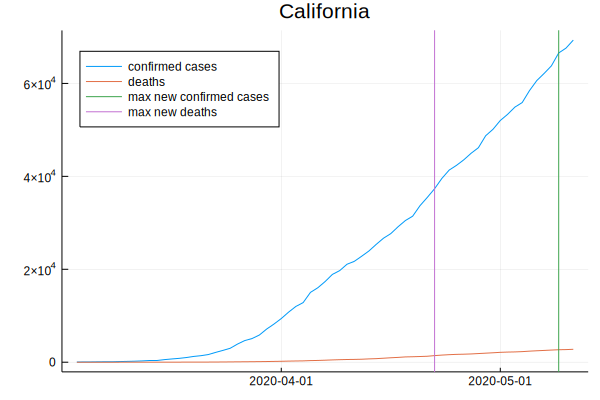

In [91]:
si = findfirst(x->x==target_state, states)
di = findfirst(x->x==statereports.death1[findfirst(x->x==target_state, states)], datelist)
@time p = plot(datelist[di:end], stateconfirm[target_state][di:end], title=target_state, label="confirmed cases", legend=:topleft)
@time plot!(p, datelist[di:end], statedeath[target_state][di:end], label="deaths")
vline!(p, [statereports.maxnewconfirm[si]], label="max new confirmed cases")
vline!(p, [statereports.maxnewdeath[si]], label="max new deaths")
savefig(p, target_state * "_raw.png")
p

  0.001864 seconds (8.70 k allocations: 247.930 KiB)
  0.000729 seconds (1.62 k allocations: 97.867 KiB)


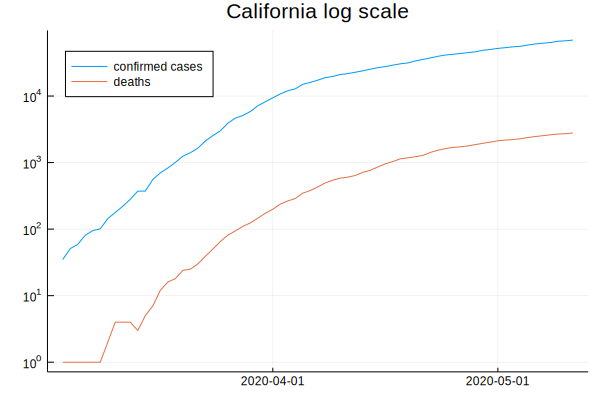

In [92]:
si = findfirst(x->x==target_state, states)
di = findfirst(x->x==statereports.death1[findfirst(x->x==target_state, states)], datelist)
@time p = plot(datelist[di:end], stateconfirm[target_state][di:end], title=target_state * " log scale", label="confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(p, datelist[di:end], statedeath[target_state][di:end], label="deaths")
savefig(p, target_state * "_raw_log.png")
p

  0.002183 seconds (8.67 k allocations: 248.242 KiB)
  0.001135 seconds (1.62 k allocations: 99.883 KiB)


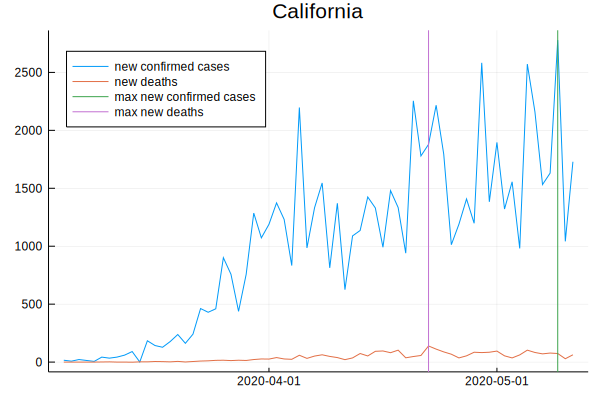

In [93]:
si = findfirst(x->x==target_state, states)
fi = findfirst(x->x==statereports.death1[si], datelist)
@time p = plot(datelist[fi+1:end], newcases(stateconfirm[target_state][fi:end]), title=target_state, 
    label="new confirmed cases", legend=:topleft)
@time plot!(p, datelist[fi+1:end], newcases(statedeath[target_state][fi:end]), label="new deaths")
vline!(p, [statereports.maxnewconfirm[si]], label="max new confirmed cases")
vline!(p, [statereports.maxnewdeath[si]], label="max new deaths")
savefig(p, target_state * "_new.png")
p

  0.001337 seconds (8.71 k allocations: 250.570 KiB)
  0.000786 seconds (1.63 k allocations: 100.508 KiB)


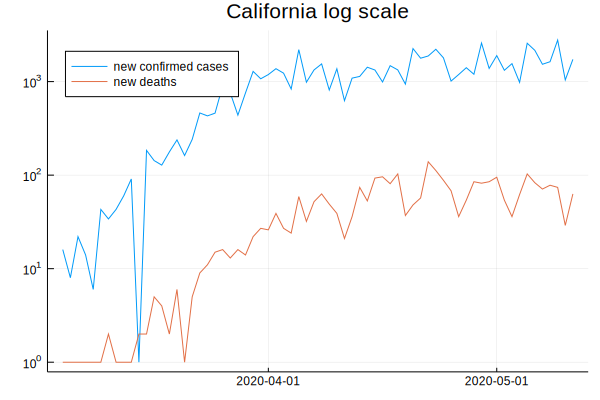

In [94]:
si = findfirst(x->x==target_state, states)
fi = findfirst(x->x==statereports.death1[si], datelist)
@time p = plot(datelist[fi+1:end], logprotect(newcases(stateconfirm[target_state][fi:end])), title=target_state * " log scale", 
    label="new confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(p, datelist[fi+1:end], logprotect(newcases(statedeath[target_state][fi:end])), label="new deaths")
savefig(p, target_state * "_new_log.png")
p

In [95]:
target_county = "Santa Cruz"

"Santa Cruz"

  0.001191 seconds (8.67 k allocations: 246.273 KiB)
  0.000863 seconds (1.62 k allocations: 97.914 KiB)


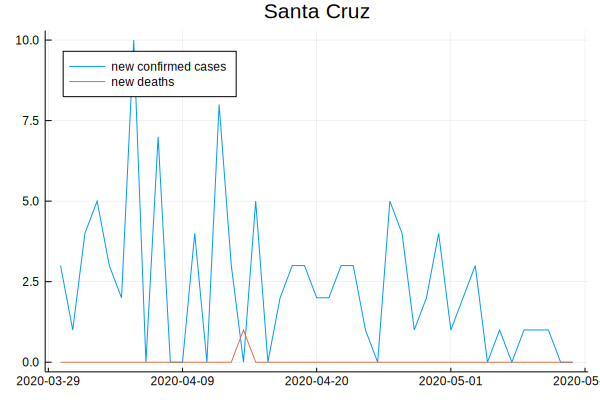

In [96]:
si = findfirst(x->x==target_county, counties)
fi = findfirst(x->x==countyreports.death1[si], datelist)
@time p = plot(datelist[fi+1:end], newcases(countyconfirm[target_county][fi:end]), title=target_county, 
    label="new confirmed cases", legend=:topleft)
@time plot!(p, datelist[fi+1:end], newcases(countydeath[target_county][fi:end]), label="new deaths")
savefig(p, target_county * "_new.png")
p

  0.000892 seconds (8.71 k allocations: 248.430 KiB)
  0.000887 seconds (1.63 k allocations: 98.367 KiB)


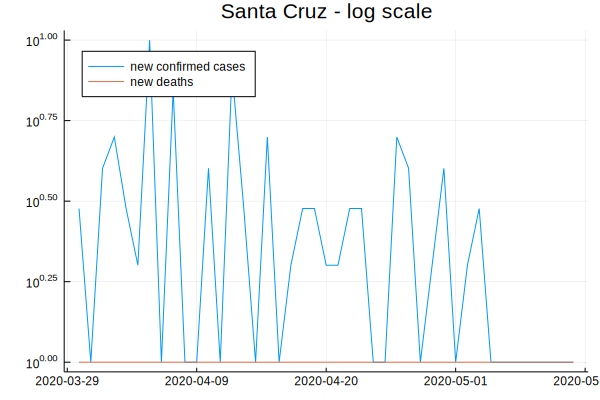

In [97]:
si = findfirst(x->x==target_county, counties)
fi = findfirst(x->x==countyreports.death1[si], datelist)
@time p = plot(datelist[fi+1:end], logprotect(newcases(countyconfirm[target_county][fi:end])), title=target_county * " - log scale", 
    label="new confirmed cases", legend=:topleft, yaxis=:log)
@time plot!(p, datelist[fi+1:end], logprotect(newcases(countydeath[target_county][fi:end])), label="new deaths")
savefig(p, target_county * "_new_log.png")
p

### single plot

In [98]:
county_choice = ["Los Angeles", "San Francisco", "Santa Cruz", "Santa Clara",]

4-element Array{String,1}:
 "Los Angeles"
 "San Francisco"
 "Santa Cruz"
 "Santa Clara"

In [99]:
@time ci = [findfirst(x->x==c, counties) for c in county_choice]

  0.069000 seconds (100.41 k allocations: 5.031 MiB)


4-element Array{Int64,1}:
 19
 38
 44
 43

In [100]:
@time mi = findmin(map(x->countyreports.confirm5[x], ci))

  0.060033 seconds (92.43 k allocations: 4.749 MiB)


(2020-03-02, 4)

In [101]:
@time start = ci[mi[2]]

  0.000011 seconds


43

  0.018435 seconds (10.49 k allocations: 570.001 KiB)


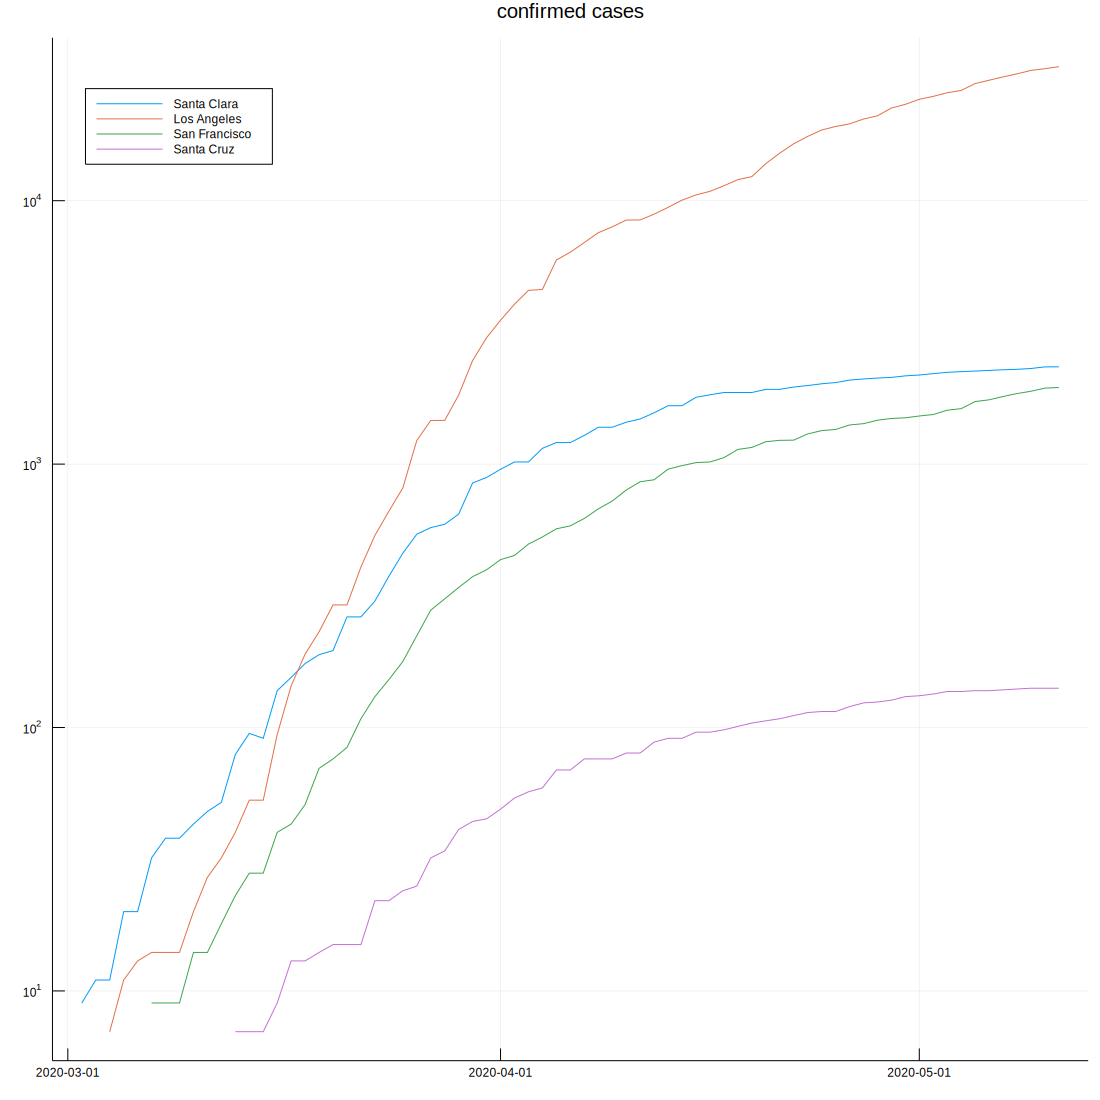

In [102]:
# log plot select confirmed cases
si = findfirst(x->x==countyreports.confirm5[start], datelist)
p = plot(datelist[si:end], logprotect(countyconfirm[counties[start]][si:end]), label=counties[start], yaxis=:log,
    legend=:topleft, size=(1100,1100), title="confirmed cases")
@time for i in vcat(ci[1:mi[2]-1], ci[mi[2]+1:end])
    si = findfirst(x->x==countyreports.confirm5[i], datelist)
    plot!(p, datelist[si:end], logprotect(countyconfirm[counties[i]][si:end]), label=counties[i])
end
savefig(p, "CAcountiesConfirm.png")
p

  0.001388 seconds (5.24 k allocations: 343.898 KiB)


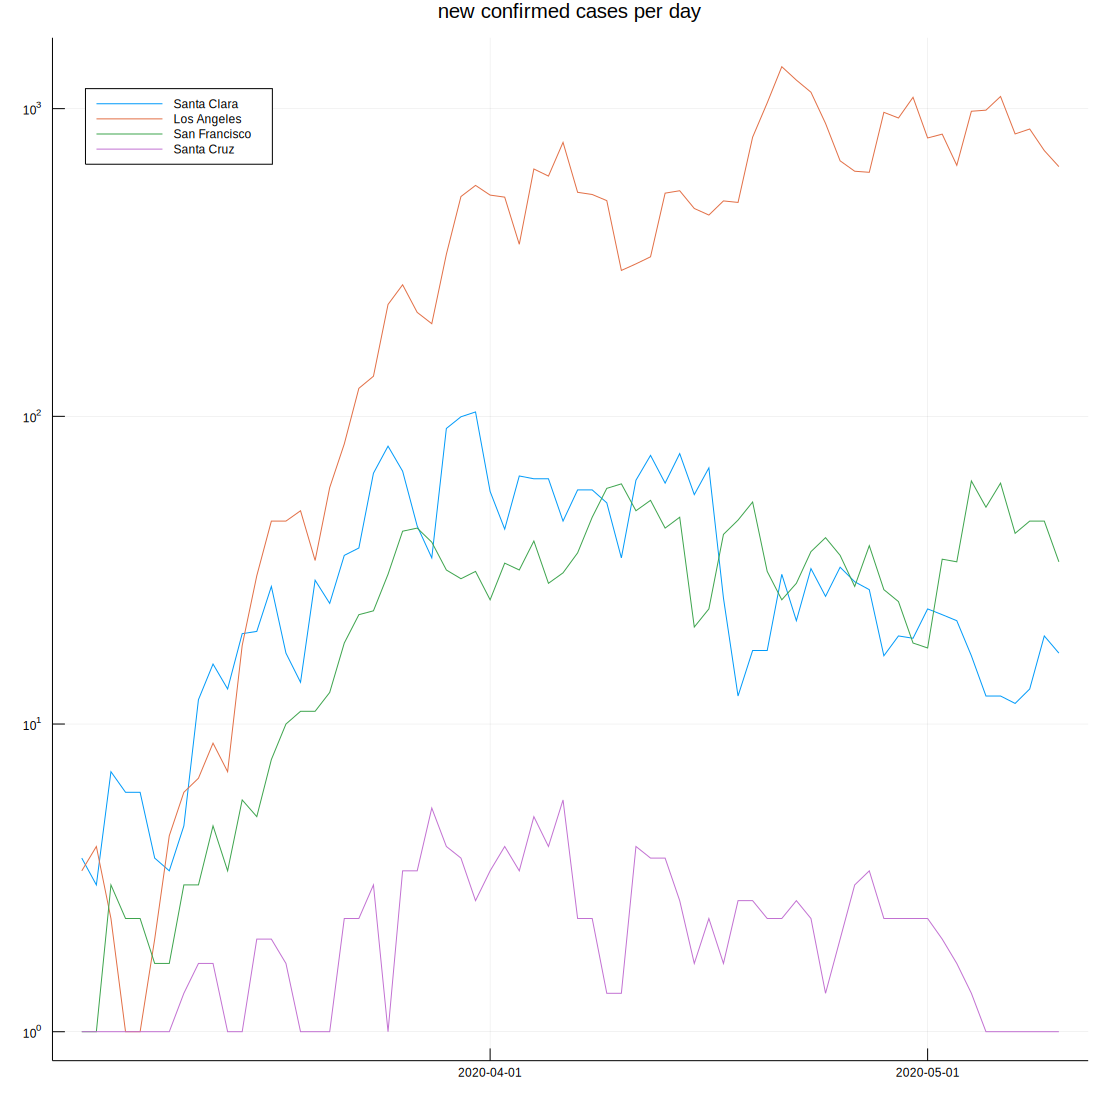

In [103]:
# plot select new cases
si = findfirst(x->x==countyreports.confirm5[start], datelist)
p = plot(datelist[si+2:end-1], logprotect(smooth(newcases(countyconfirm[counties[start]]), 3)[si:end]), label=counties[start], yaxis=:log,
    legend=:topleft, size=(1100,1100), title="new confirmed cases per day")
@time for i in vcat(ci[1:mi[2]-1], ci[mi[2]+1:end])
    plot!(p, datelist[si+2:end-1], logprotect(smooth(newcases(countyconfirm[counties[i]]), 3)[si:end]), label=counties[i])
end
savefig(p, "CAcountiesNewConfirm.png")
p

  0.001315 seconds (5.24 k allocations: 343.898 KiB)


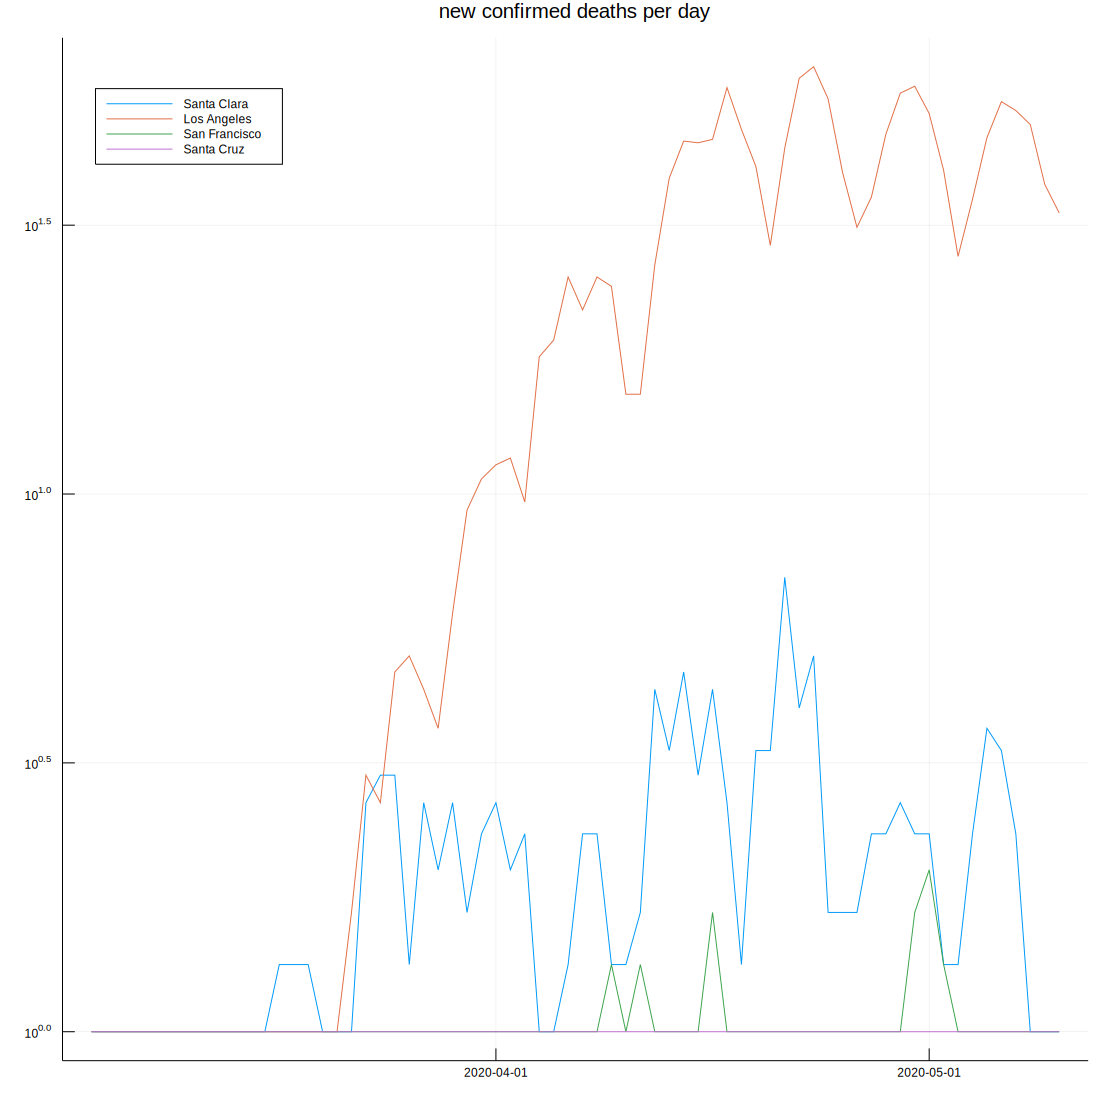

In [104]:
# plot select new deaths
si = findfirst(x->x==countyreports.confirm5[start], datelist)
p = plot(datelist[si+2:end-1], logprotect(smooth(newcases(countydeath[counties[start]]), 3)[si:end]), label=counties[start], yaxis=:log,
    legend=:topleft, size=(1100,1100), title="new confirmed deaths per day")
@time for i in vcat(ci[1:mi[2]-1], ci[mi[2]+1:end])
    plot!(p, datelist[si+2:end-1], logprotect(smooth(newcases(countydeath[counties[i]]), 3)[si:end]), label=counties[i])
end
savefig(p, "CAcountyNewdeath.png")
p